<a href="https://colab.research.google.com/github/bsshreesha/Physics_Informed_Neural_Network/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Starting PINN training for 20000 epochs with RL-adjusted lambda_bc (Extended System)...
Epoch 1/20000 - Total Loss: 6.012e+01, ODE Loss: 7.647e-03, BC Loss: 3.006e+00, lambda_bc: 20.00, LR: 1.00e-03
Epoch 1000/20000 - Total Loss: 9.150e-03, ODE Loss: 8.847e-03, BC Loss: 2.024e-04, lambda_bc: 1.50, LR: 9.50e-04
Epoch 2000/20000 - Total Loss: 6.894e-03, ODE Loss: 6.603e-03, BC Loss: 2.906e-04, lambda_bc: 1.00, LR: 9.03e-04
Epoch 3000/20000 - Total Loss: 5.110e-03, ODE Loss: 4.947e-03, BC Loss: 1.627e-04, lambda_bc: 1.00, LR: 8.57e-04
Epoch 4000/20000 - Total Loss: 5.890e-04, ODE Loss: 5.798e-04, BC Loss: 9.163e-06, lambda_bc: 1.00, LR: 8.15e-04
Epoch 5000/20000 - Total Loss: 2.276e-04, ODE Loss: 2.274e-04, BC Loss: 1.877e-07, lambda_bc: 1.00, LR: 7.74e-04
Epoch 6000/20000 - Total Loss: 1.142e-04, ODE Loss: 1.141e-04, BC Loss: 8.631e-08, lambda_bc: 1.00, LR: 7.35e-04
Epoch 7000/20000 - Total Loss: 9.575e-05, ODE Loss: 9.562e-05, BC Loss: 1.365e-07, lambda_bc: 1.00, LR: 6.98e-04
Epoch 8000

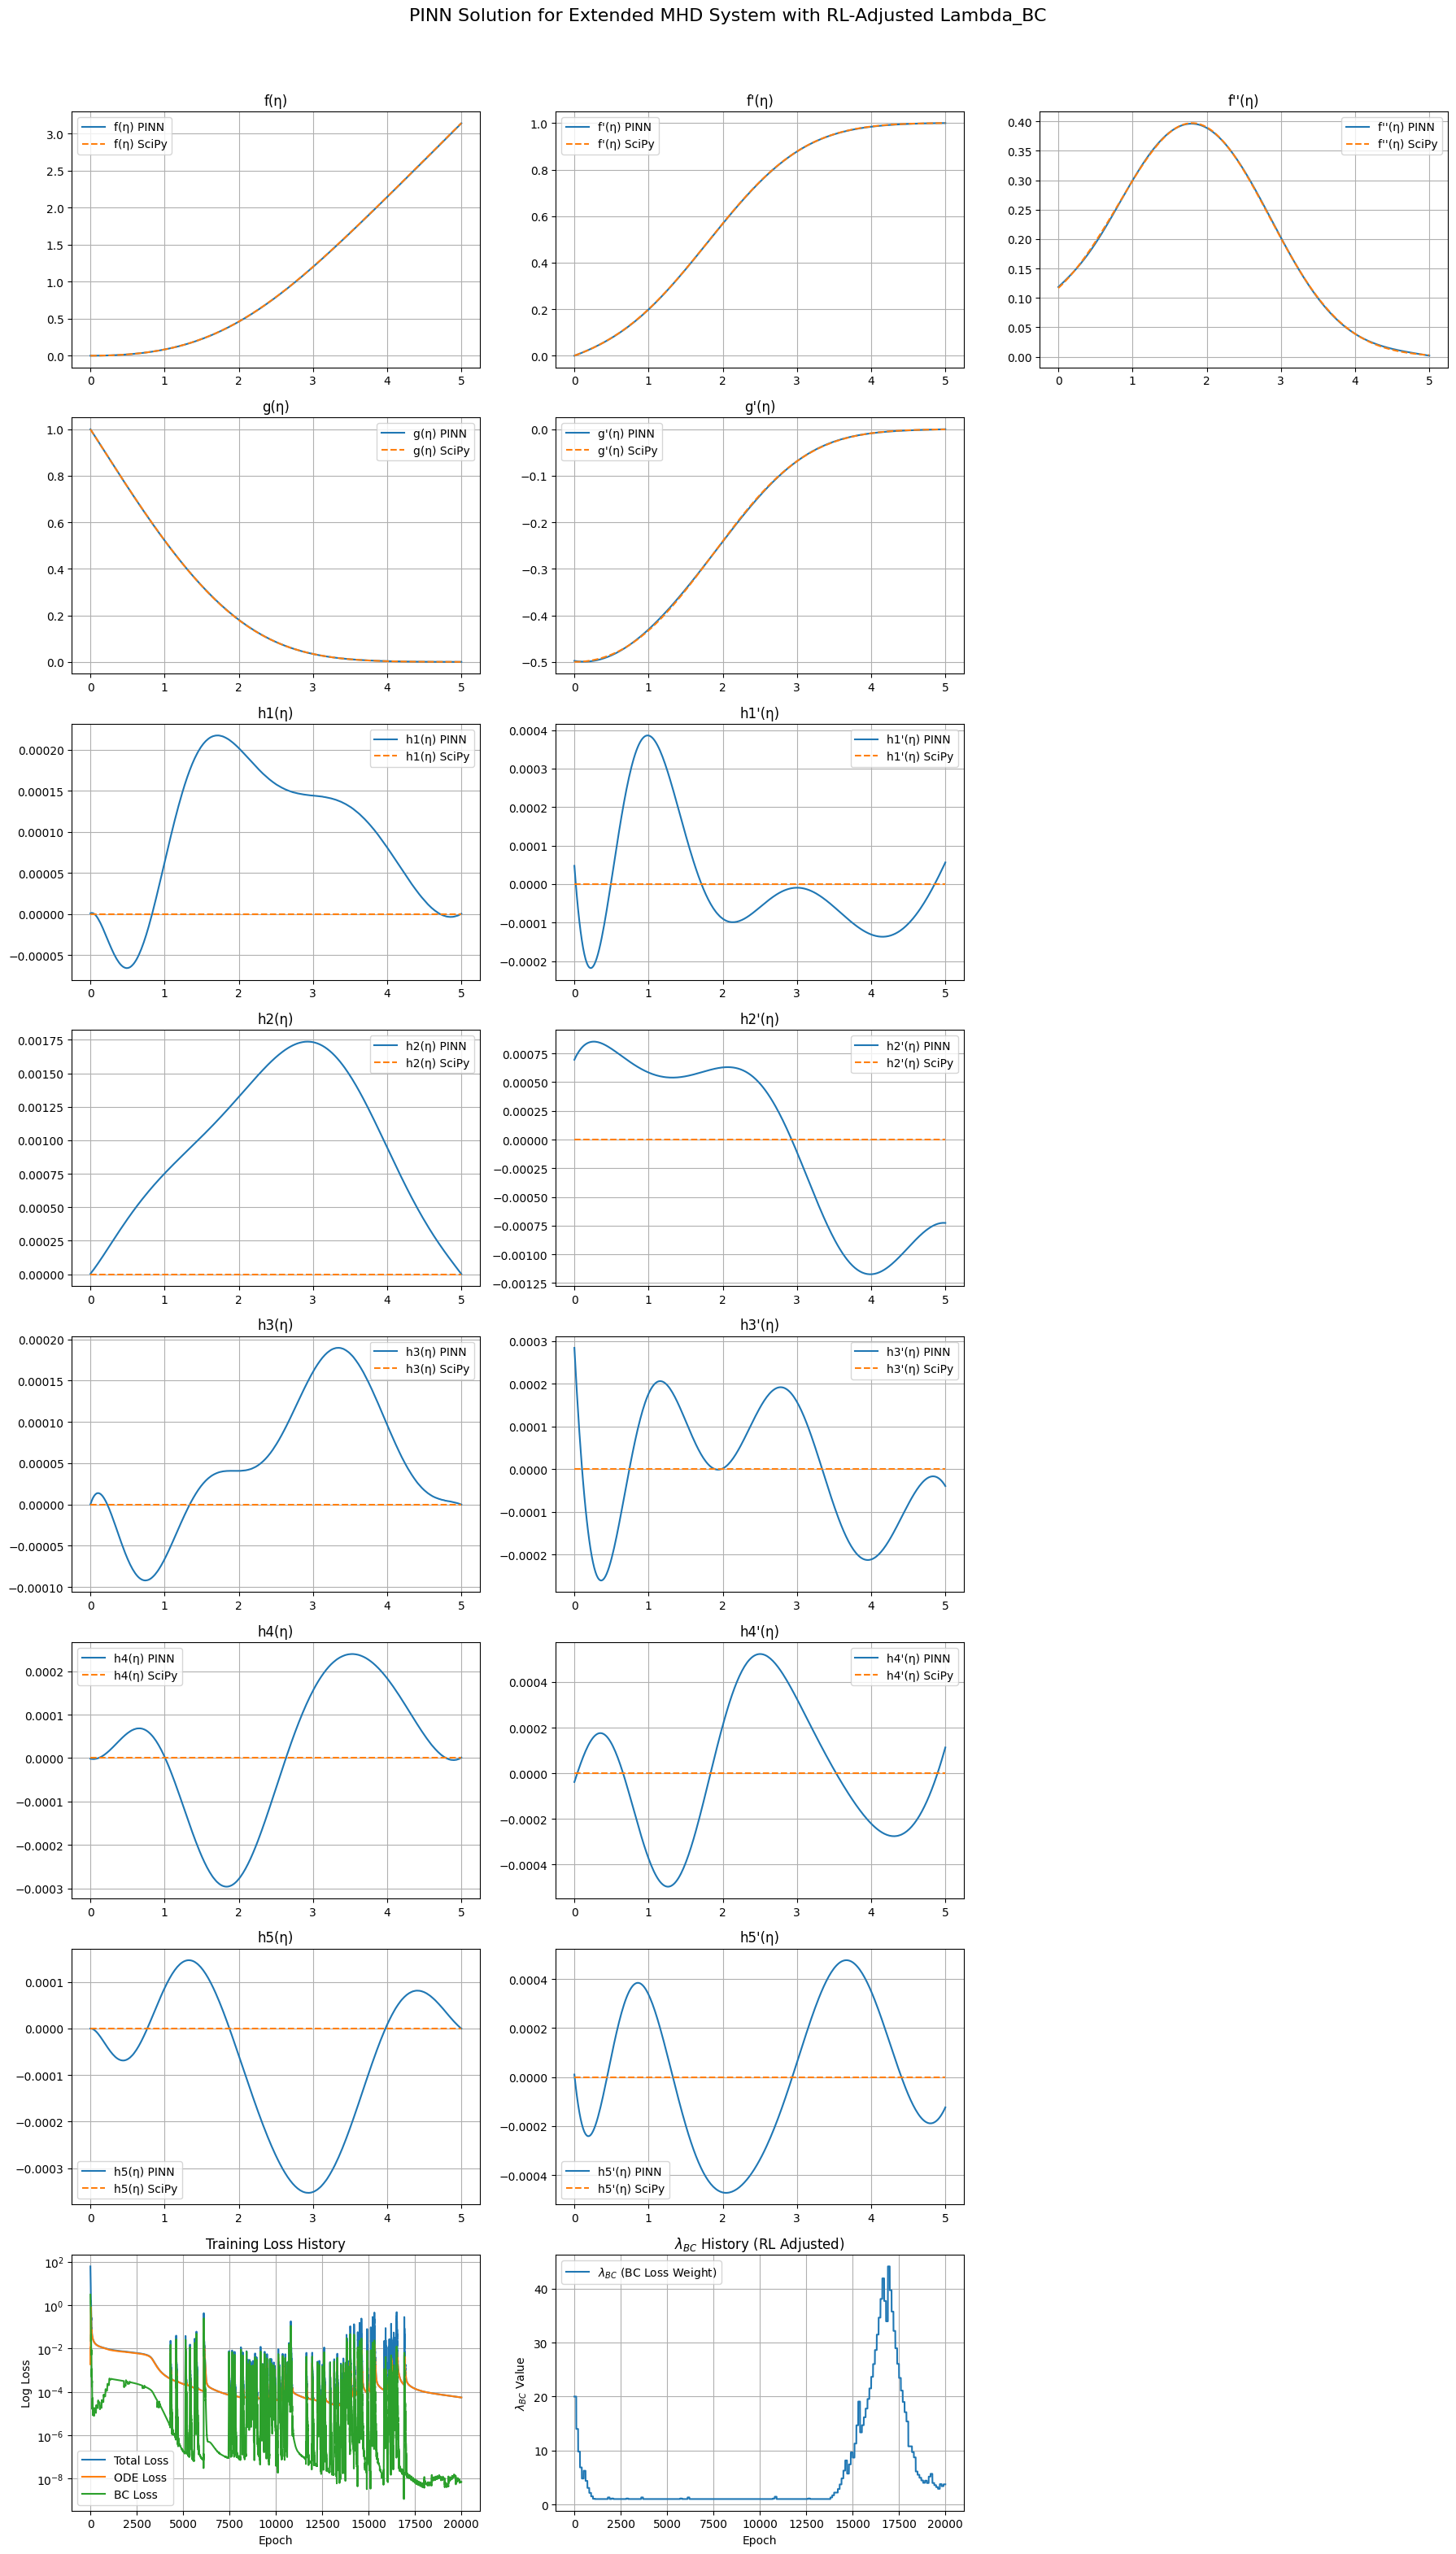


--- Final Loss Metrics (Extended System) ---
Final Total Loss: 5.4655e-05
Final ODE Residual Loss: 5.4629e-05
Final Boundary Condition Loss: 6.9257e-09
Final lambda_bc: 3.73
Mean Squared Error (PINN vs SciPy) for f(η): 4.2200e-06
Mean Squared Error (PINN vs SciPy) for g(η): 2.6443e-07
Mean Squared Error (PINN vs SciPy) for h1(η): 1.5928e-08
Mean Squared Error (PINN vs SciPy) for h2(η): 1.2381e-06
Mean Squared Error (PINN vs SciPy) for h3(η): 8.4838e-09
Mean Squared Error (PINN vs SciPy) for h4(η): 2.5387e-08
Mean Squared Error (PINN vs SciPy) for h5(η): 2.8005e-08

Core neural network model for the extended system saved to extended_mhd_pinn_rl_model.h5

--- Note on this RL Implementation ---

The Reinforcement Learning (RL) component added here is a *simplified Q-learning agent*
for illustrative purposes. It attempts to tune the 'lambda_bc' hyperparameter.
Real-world RL for PINN optimization would typically involve:
- More sophisticated state representations.
- More complex action spa

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
import collections # For Q-table using defaultdict

# Suppress TensorFlow warnings for cleaner output
import logging
tf.get_logger().setLevel(logging.ERROR)

# --- 1. Define MHD and New System Parameters and Domain ---
M = 1.0
Pr_m = 1.0
ETA_MAX = 5.0 # Consider if ETA_MAX needs adjustment for more complex systems

# Parameters for the 5 new equations (h1 to h5)
# These are placeholders; they should be chosen based on the "more realistic" physics intended.
K_params = {
    'K1': tf.constant(0.5, dtype=tf.float32), 'K2': tf.constant(0.5, dtype=tf.float32),
    'K3': tf.constant(0.3, dtype=tf.float32), 'K4': tf.constant(0.2, dtype=tf.float32),
    'K5': tf.constant(0.4, dtype=tf.float32), 'K6': tf.constant(0.4, dtype=tf.float32),
    'K7': tf.constant(0.6, dtype=tf.float32), 'K8': tf.constant(0.3, dtype=tf.float32),
    'K9': tf.constant(0.2, dtype=tf.float32), 'K10': tf.constant(0.5, dtype=tf.float32),
}

# --- 2. Define the Neural Network Architecture ---
def create_pinn_model_extended(num_hidden_layers=4, num_neurons_per_layer=64): # Increased neurons for more outputs
    eta_input = tf.keras.Input(shape=(1,), name="eta")
    x = eta_input
    for _ in range(num_hidden_layers):
        x = tf.keras.layers.Dense(num_neurons_per_layer, activation="tanh")(x)
    # Output f, g, h1, h2, h3, h4, h5 (7 outputs)
    f_output = tf.keras.layers.Dense(1, name="f", activation='linear')(x)
    g_output = tf.keras.layers.Dense(1, name="g", activation='linear')(x)
    h1_output = tf.keras.layers.Dense(1, name="h1", activation='linear')(x)
    h2_output = tf.keras.layers.Dense(1, name="h2", activation='linear')(x)
    h3_output = tf.keras.layers.Dense(1, name="h3", activation='linear')(x)
    h4_output = tf.keras.layers.Dense(1, name="h4", activation='linear')(x)
    h5_output = tf.keras.layers.Dense(1, name="h5", activation='linear')(x)
    return tf.keras.Model(inputs=eta_input, outputs=[f_output, g_output, h1_output, h2_output, h3_output, h4_output, h5_output])

# --- 3. Define the Extended PINN Model ---
class Extended_MHD_PINN(tf.keras.Model):
    def __init__(self, nn_approximator, m_param, pr_m_param, k_params_dict, eta_max_val, initial_lambda_bc=10.0, **kwargs):
        super().__init__(**kwargs)
        self.nn = nn_approximator
        self.M = tf.constant(m_param, dtype=tf.float32)
        self.Pr_m = tf.constant(pr_m_param, dtype=tf.float32)
        self.K = k_params_dict # Store the dictionary of K_params
        self.eta_max = tf.constant(eta_max_val, dtype=tf.float32)
        self.lambda_ode = tf.constant(1.0, dtype=tf.float32)
        self.lambda_bc = tf.Variable(initial_lambda_bc, dtype=tf.float32, trainable=False, name="lambda_bc")

    def set_lambda_bc(self, new_lambda_bc_value):
        self.lambda_bc.assign(np.clip(new_lambda_bc_value, 1.0, 1000.0)) # Adjusted upper clip for potentially larger BC losses

    def call(self, eta):
        return self.nn(eta)

    @tf.function
    def compute_derivatives_and_residuals(self, eta_collocation):
        with tf.GradientTape(persistent=True) as tape_outer: # For 3rd order f
            tape_outer.watch(eta_collocation)
            with tf.GradientTape(persistent=True) as tape_mid: # For 2nd order f, g, h_i
                tape_mid.watch(eta_collocation)
                with tf.GradientTape(persistent=True) as tape_inner: # For 1st order f, g, h_i
                    tape_inner.watch(eta_collocation)
                    # Get all 7 outputs from the neural network
                    f_pred, g_pred, h1_pred, h2_pred, h3_pred, h4_pred, h5_pred = self.nn(eta_collocation)

                # First derivatives
                df_deta = tape_inner.gradient(f_pred, eta_collocation)
                dg_deta = tape_inner.gradient(g_pred, eta_collocation)
                dh1_deta = tape_inner.gradient(h1_pred, eta_collocation)
                dh2_deta = tape_inner.gradient(h2_pred, eta_collocation)
                dh3_deta = tape_inner.gradient(h3_pred, eta_collocation)
                dh4_deta = tape_inner.gradient(h4_pred, eta_collocation)
                dh5_deta = tape_inner.gradient(h5_pred, eta_collocation)
            del tape_inner # Release inner tape

            # Second derivatives
            df_deta2 = tape_mid.gradient(df_deta, eta_collocation)
            dg_deta2 = tape_mid.gradient(dg_deta, eta_collocation)
            dh1_deta2 = tape_mid.gradient(dh1_deta, eta_collocation)
            dh2_deta2 = tape_mid.gradient(dh2_deta, eta_collocation)
            dh3_deta2 = tape_mid.gradient(dh3_deta, eta_collocation)
            dh4_deta2 = tape_mid.gradient(dh4_deta, eta_collocation)
            dh5_deta2 = tape_mid.gradient(dh5_deta, eta_collocation)
        del tape_mid # Release mid tape

        # Third derivative for f
        df_deta3 = tape_outer.gradient(df_deta2, eta_collocation)
        del tape_outer # Release outer tape

        f, fp, fpp, fppp = f_pred, df_deta, df_deta2, df_deta3
        g, gp, gpp = g_pred, dg_deta, dg_deta2
        h_preds = [h1_pred, h2_pred, h3_pred, h4_pred, h5_pred]
        hp_preds = [dh1_deta, dh2_deta, dh3_deta, dh4_deta, dh5_deta]
        hpp_preds = [dh1_deta2, dh2_deta2, dh3_deta2, dh4_deta2, dh5_deta2]

        # Original MHD Residuals
        residual_f = fppp + f * fpp - self.M * (g * gpp + fpp * g)
        residual_g = gpp + self.Pr_m * (f * gp - fp * g)

        # New Residuals for h1 to h5 (example definitions based on user's intent for higher-order system)
        # These are example forms; replace with actual physical equations.
        # h1'' + K1*f*h1' - K2*g*h1 = 0
        res_h1 = hpp_preds[0] + self.K['K1'] * f * hp_preds[0] - self.K['K2'] * g * h_preds[0]
        # h2'' + K3*f'*h2 - K4*g'*h2' = 0
        res_h2 = hpp_preds[1] + self.K['K3'] * fp * h_preds[1] - self.K['K4'] * gp * hp_preds[1]
        # h3'' + K5*h1'*h3 - K6*h2*h3' = 0 (using h_preds[0] for h1, h_preds[1] for h2)
        res_h3 = hpp_preds[2] + self.K['K5'] * hp_preds[0] * h_preds[2] - self.K['K6'] * h_preds[1] * hp_preds[2]
        # h4'' + K7*f*h4' - K8*h1*h4 = 0
        res_h4 = hpp_preds[3] + self.K['K7'] * f * hp_preds[3] - self.K['K8'] * h_preds[0] * h_preds[3]
        # h5'' + K9*g*h5' - K10*h2*h5 = 0
        res_h5 = hpp_preds[4] + self.K['K9'] * g * hp_preds[4] - self.K['K10'] * h_preds[1] * h_preds[4]

        residuals_h_list = [res_h1, res_h2, res_h3, res_h4, res_h5]
        return residual_f, residual_g, residuals_h_list

    @tf.function
    def loss_fn(self, eta_collocation, eta_boundary_0, eta_boundary_max):
        res_f, res_g, residuals_h_list = self.compute_derivatives_and_residuals(eta_collocation)
        loss_ode_f = tf.reduce_mean(tf.square(res_f))
        loss_ode_g = tf.reduce_mean(tf.square(res_g))
        loss_ode_h_sum = tf.constant(0.0, dtype=tf.float32)
        for res_h_i in residuals_h_list:
            loss_ode_h_sum += tf.reduce_mean(tf.square(res_h_i))
        total_loss_ode = loss_ode_f + loss_ode_g + loss_ode_h_sum

        # Boundary conditions
        outputs_at_0 = self.nn(eta_boundary_0) # f, g, h1..h5 at eta=0
        f_at_0, g_at_0 = outputs_at_0[0], outputs_at_0[1]
        h_at_0_list = outputs_at_0[2:] # List of h_i tensors at eta=0

        # Derivatives for BCs at eta=0
        with tf.GradientTape(persistent=True) as tape_bc0:
            tape_bc0.watch(eta_boundary_0)
            # Re-evaluate NN at boundary for gradient calculation
            f_bc0, g_bc0_dummy, h1_bc0, h2_bc0, h3_bc0, h4_bc0, h5_bc0 = self.nn(eta_boundary_0)
        f_prime_at_0 = tape_bc0.gradient(f_bc0, eta_boundary_0)
        # Example: dh1_deta_at_0 = tape_bc0.gradient(h1_bc0, eta_boundary_0) # if needed for BCs

        # BCs for f and g at eta=0
        bc_f0_val = f_at_0 - 0.0
        bc_fprime0_val = f_prime_at_0 - 0.0
        bc_g0_val = g_at_0 - 1.0

        outputs_at_max = self.nn(eta_boundary_max) # f, g, h1..h5 at eta=eta_max
        f_at_max, g_at_max = outputs_at_max[0], outputs_at_max[1] # f_at_max needed for f_prime_at_max
        h_at_max_list = outputs_at_max[2:] # List of h_i tensors at eta=eta_max

        # Derivatives for BCs at eta=eta_max
        with tf.GradientTape(persistent=True) as tape_bc_max:
            tape_bc_max.watch(eta_boundary_max)
            f_bc_max, g_bc_max_dummy, h1_bc_max, h2_bc_max, h3_bc_max, h4_bc_max, h5_bc_max = self.nn(eta_boundary_max)
        f_prime_at_max = tape_bc_max.gradient(f_bc_max, eta_boundary_max)
        # Example: dh1_deta_at_max = tape_bc_max.gradient(h1_bc_max, eta_boundary_max)

        del tape_bc0, tape_bc_max # Important to delete persistent tapes

        # BCs for f and g at eta=eta_max
        bc_fprime_max_val = f_prime_at_max - 1.0
        bc_g_max_val = g_at_max - 0.0

        loss_bc_fg = (tf.reduce_mean(tf.square(bc_f0_val)) +
                      tf.reduce_mean(tf.square(bc_fprime0_val)) +
                      tf.reduce_mean(tf.square(bc_g0_val)) +
                      tf.reduce_mean(tf.square(bc_fprime_max_val)) +
                      tf.reduce_mean(tf.square(bc_g_max_val)))

        # Boundary conditions for h1 to h5
        # Example: h_i(0) = 0, h_i(ETA_MAX) = 0. Adjust as per actual BCs.
        loss_bc_h_sum = tf.constant(0.0, dtype=tf.float32)
        for i in range(5):
            # h_i(0) = 0
            bc_hi_0_val = h_at_0_list[i] - 0.0
            loss_bc_h_sum += tf.reduce_mean(tf.square(bc_hi_0_val))
            # h_i(ETA_MAX) = 0
            bc_hi_max_val = h_at_max_list[i] - 0.0
            loss_bc_h_sum += tf.reduce_mean(tf.square(bc_hi_max_val))
            # If BCs involve derivatives of h_i, calculate them using tape_bc0/tape_bc_max
            # and add their squared errors to loss_bc_h_sum. For example:
            # dh_i_deta_at_0 = tape_bc0.gradient(h_bc0_list[i], eta_boundary_0) # (assuming h_bc0_list was defined)
            # loss_bc_h_sum += tf.reduce_mean(tf.square(dh_i_deta_at_0 - target_derivative_val_at_0))

        total_loss_bc = loss_bc_fg + loss_bc_h_sum
        total_loss = self.lambda_ode * total_loss_ode + self.lambda_bc * total_loss_bc
        return total_loss, total_loss_ode, total_loss_bc

    @tf.function
    def gradient_update_step(self, optimizer, eta_collocation, eta_boundary_0, eta_boundary_max):
        with tf.GradientTape() as tape:
            total_loss, loss_ode, loss_bc = self.loss_fn(eta_collocation, eta_boundary_0, eta_boundary_max)
        gradients = tape.gradient(total_loss, self.nn.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.nn.trainable_variables))
        return total_loss, loss_ode, loss_bc

# --- 4. Q-Learning Agent for Adjusting lambda_bc (Unchanged) ---
class QLearningAgent:
    def __init__(self, actions, learning_rate=0.1, discount_factor=0.9, exploration_rate=0.1):
        self.actions = actions
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.q_table = collections.defaultdict(lambda: np.zeros(len(actions)))

    def get_state(self, loss_ode, loss_bc, epoch, total_epochs):
        if loss_ode < 1e-12 and loss_bc < 1e-12: ratio_discrete = 1
        elif loss_ode < 1e-12: ratio_discrete = 2 # BC dominant if ODE is zero
        elif loss_bc < 1e-12: ratio_discrete = 0 # ODE dominant if BC is zero
        else:
            ratio = loss_bc / loss_ode
            if ratio < 0.5: ratio_discrete = 0 # ODE dominant
            elif ratio > 2.0: ratio_discrete = 2 # BC dominant
            else: ratio_discrete = 1 # Balanced
        if epoch < total_epochs / 3: phase = 0 # Early
        elif epoch < 2 * total_epochs / 3: phase = 1 # Mid
        else: phase = 2 # Late
        return (ratio_discrete, phase)

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(len(self.actions)) # Explore
        else:
            q_values = self.q_table[state]
            return np.argmax(q_values) # Exploit

    def update_q_table(self, state, action_idx, reward, next_state):
        old_q_value = self.q_table[state][action_idx]
        future_q_value = np.max(self.q_table[next_state]) if next_state in self.q_table else 0.0
        new_q_value = old_q_value + self.lr * (reward + self.gamma * future_q_value - old_q_value)
        self.q_table[state][action_idx] = new_q_value

# --- 5. Generate Training Data (Unchanged from previous extended version) ---
N_collocation = 2000
N_boundary = 200
eta_col_np = np.random.uniform(1e-5, ETA_MAX - 1e-5, (N_collocation, 1)).astype(np.float32)
eta_b0_np = np.full((N_boundary, 1), 0.0, dtype=np.float32)
eta_b_max_np = np.full((N_boundary, 1), ETA_MAX, dtype=np.float32)
eta_col = tf.constant(eta_col_np)
eta_b0 = tf.constant(eta_b0_np)
eta_b_max = tf.constant(eta_b_max_np)

# --- 6. Training the Extended PINN with RL Agent ---
# Increased capacity for the more complex system
nn_core_model_ext = create_pinn_model_extended(num_hidden_layers=5, num_neurons_per_layer=128)
initial_lambda_bc_val = 20.0 # May need tuning
pinn_solver_ext = Extended_MHD_PINN(nn_core_model_ext, M, Pr_m, K_params, ETA_MAX, initial_lambda_bc=initial_lambda_bc_val)

initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.95, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

epochs = 20000 # Increased epochs for the more complex system
print_interval = 1000
rl_update_interval = 100 # Update RL agent's policy

lambda_bc_actions_multipliers = [0.7, 0.9, 1.0, 1.1, 1.3] # Actions for RL agent
rl_agent = QLearningAgent(actions=lambda_bc_actions_multipliers, exploration_rate=0.25)

print(f"Starting PINN training for {epochs} epochs with RL-adjusted lambda_bc (Extended System)...")
history_loss = []
history_loss_ode = []
history_loss_bc = []
history_lambda_bc = []

for epoch in range(epochs):
    current_lambda_bc_before_rl_action = pinn_solver_ext.lambda_bc.numpy()
    lambda_to_log_this_epoch = current_lambda_bc_before_rl_action # Default value to log

    if epoch > 0 and epoch % rl_update_interval == 0 :
        if not history_loss_ode or not history_loss_bc: # Should ideally not happen after first few steps
            # Use current losses if history is empty, or default to a neutral state.
            # This part might need refinement if it's hit often.
            # For now, using last known losses if available, else a placeholder.
            last_ode_loss = history_loss_ode[-1] if history_loss_ode else 0.1
            last_bc_loss = history_loss_bc[-1] if history_loss_bc else 0.1
            state = rl_agent.get_state(last_ode_loss, last_bc_loss, epoch, epochs)
        else:
            state = rl_agent.get_state(history_loss_ode[-1], history_loss_bc[-1], epoch, epochs)

        action_idx = rl_agent.choose_action(state)
        multiplier = rl_agent.actions[action_idx]
        new_lambda_bc = pinn_solver_ext.lambda_bc.numpy() * multiplier
        pinn_solver_ext.set_lambda_bc(new_lambda_bc)
        lambda_to_log_this_epoch = pinn_solver_ext.lambda_bc.numpy() # Log the new lambda

    # Perform one training step
    total_loss_val, loss_ode_val, loss_bc_val = pinn_solver_ext.gradient_update_step(
        optimizer, eta_col, eta_b0, eta_b_max
    )

    # Update RL agent's Q-table after the training step (and after losses for this step are known)
    if epoch > 0 and epoch % rl_update_interval == 0 :
        # Reward calculation: negative change in total loss over the interval
        # A positive reward means the loss decreased.
        if len(history_loss) >= rl_update_interval :
            # Compare current total loss with the loss at the start of this RL interval
            reward = -(total_loss_val.numpy() - history_loss[-rl_update_interval])
        elif history_loss: # Fallback: compare with the immediately previous loss
            reward = -(total_loss_val.numpy() - history_loss[-1])
        else: # First RL update, no prior loss for comparison over an interval
            reward = -total_loss_val.numpy() # Reward is simply negative current loss

        # Get the state resulting from the action taken and the training step
        next_state = rl_agent.get_state(loss_ode_val.numpy(), loss_bc_val.numpy(), epoch + 1, epochs) # epoch+1 as it's for the *next* state
        rl_agent.update_q_table(state, action_idx, reward, next_state) # 'state' was from before this step's RL action

    # Log history
    history_loss.append(total_loss_val.numpy())
    history_loss_ode.append(loss_ode_val.numpy())
    history_loss_bc.append(loss_bc_val.numpy())
    history_lambda_bc.append(lambda_to_log_this_epoch) # Log the lambda active for this training step

    if (epoch + 1) % print_interval == 0 or epoch == 0:
        # CORRECTED LINE: Access optimizer.learning_rate directly if it's an EagerTensor
        # If optimizer.learning_rate is the schedule object, then optimizer.learning_rate(optimizer.iterations) is correct.
        # Given the error, we assume optimizer.learning_rate is already the evaluated tensor.
        current_lr_val = optimizer.learning_rate
        if callable(optimizer.learning_rate): # If it's the schedule object
            current_lr_val = optimizer.learning_rate(optimizer.iterations)

        print(f"Epoch {epoch+1}/{epochs} - Total Loss: {total_loss_val:.3e}, "
              f"ODE Loss: {loss_ode_val:.3e}, BC Loss: {loss_bc_val:.3e}, "
              f"lambda_bc: {lambda_to_log_this_epoch:.2f}, LR: {current_lr_val.numpy():.2e}")

print("Training finished.")


# --- 7. Prediction and Plotting (Extended) ---
print("\nGenerating predictions and plots for the extended system...")
eta_plot_tf = tf.constant(np.linspace(0, ETA_MAX, 300).reshape(-1, 1).astype(np.float32))
outputs_pinn_pred_tf = pinn_solver_ext.nn(eta_plot_tf)
f_pinn_pred = outputs_pinn_pred_tf[0].numpy()
g_pinn_pred = outputs_pinn_pred_tf[1].numpy()
h_pinn_preds = [h_tf.numpy() for h_tf in outputs_pinn_pred_tf[2:]]

# Derivatives for plotting
with tf.GradientTape(persistent=True) as tape_plot_outer:
    tape_plot_outer.watch(eta_plot_tf)
    with tf.GradientTape(persistent=True) as tape_plot_mid:
        tape_plot_mid.watch(eta_plot_tf)
        with tf.GradientTape(persistent=True) as tape_plot_inner:
            tape_plot_inner.watch(eta_plot_tf)
            f_plot, g_plot, h1_plot, h2_plot, h3_plot, h4_plot, h5_plot = pinn_solver_ext.nn(eta_plot_tf)

        fp_plot = tape_plot_inner.gradient(f_plot, eta_plot_tf)
        gp_plot = tape_plot_inner.gradient(g_plot, eta_plot_tf)
        hp_plots_tf = [tape_plot_inner.gradient(h_plot, eta_plot_tf) for h_plot in [h1_plot, h2_plot, h3_plot, h4_plot, h5_plot]]
    del tape_plot_inner

    fpp_plot = tape_plot_mid.gradient(fp_plot, eta_plot_tf)
    # gpp_plot = tape_plot_mid.gradient(gp_plot, eta_plot_tf) # Can be calculated if needed for plotting
    hpp_plots_tf = [tape_plot_mid.gradient(hp_p, eta_plot_tf) for hp_p in hp_plots_tf]
del tape_plot_mid, tape_plot_outer


f_prime_pinn_pred = fp_plot.numpy()
g_prime_pinn_pred = gp_plot.numpy()
f_prime_prime_pinn_pred = fpp_plot.numpy()
h_prime_pinn_preds = [hp.numpy() for hp in hp_plots_tf]
# h_prime_prime_pinn_preds = [hpp.numpy() for hpp in hpp_plots_tf] # For plotting h'' if needed


# SciPy Solution for the Extended System
# State vector y: [f, f', f'', g, g', h1, h1', h2, h2', h3, h3', h4, h4', h5, h5'] (15 elements for f,g + 5*h)
# Total 3 (for f) + 2 (for g) + 5*2 (for h_i) = 15 elements if all h_i are 2nd order.
# The PINN calculates f''' but SciPy needs f, f', f''. So for f, we track 3 states.
# For g, g', g'' (PINN), SciPy needs g, g'. So 2 states.
# For h_i, h_i', h_i'' (PINN), SciPy needs h_i, h_i'. So 2 states for each h_i.
# Total states for SciPy: f, f', f'', g, g', h1, h1', ..., h5, h5' => 3 + 2 + 5*2 = 15 states.

def extended_mhd_ode_system_scipy(eta, y, M_param, Pr_m_param, K_vals_dict):
    # Unpack all 15 state variables
    f_val, fp_val, fpp_val = y[0], y[1], y[2]
    g_val, gp_val = y[3], y[4]
    h_vals = [y[5+2*i] for i in range(5)]
    hp_vals = [y[6+2*i] for i in range(5)]

    # Calculate second derivatives needed for third/second order equations
    # g'' = -Pr_m * (f * g' - f' * g)
    gpp_val = -Pr_m_param * (f_val * gp_val - fp_val * g_val)

    # f''' = -f*f'' + M*(g*g'' + f''*g)
    fppp_val = -f_val * fpp_val + M_param * (g_val * gpp_val + fpp_val * g_val) # Corrected based on PINN residual form

    # Calculate h_i'' based on their ODE definitions (must match PINN residuals)
    # Example forms used in PINN:
    # h1'' = -K1*f*h1' + K2*g*h1
    h1pp_val = -K_vals_dict['K1'] * f_val * hp_vals[0] + K_vals_dict['K2'] * g_val * h_vals[0]
    # h2'' = -K3*f'*h2 + K4*g'*h2'
    h2pp_val = -K_vals_dict['K3'] * fp_val * h_vals[1] + K_vals_dict['K4'] * gp_val * hp_vals[1]
    # h3'' = -K5*h1'*h3 + K6*h2*h3'
    h3pp_val = -K_vals_dict['K5'] * hp_vals[0] * h_vals[2] + K_vals_dict['K6'] * h_vals[1] * hp_vals[2]
    # h4'' = -K7*f*h4' + K8*h1*h4
    h4pp_val = -K_vals_dict['K7'] * f_val * hp_vals[3] + K_vals_dict['K8'] * h_vals[0] * h_vals[3]
    # h5'' = -K9*g*h5' + K10*h2*h5
    h5pp_val = -K_vals_dict['K9'] * g_val * hp_vals[4] + K_vals_dict['K10'] * h_vals[1] * h_vals[4]

    hpp_vals_calculated = [h1pp_val, h2pp_val, h3pp_val, h4pp_val, h5pp_val]

    # Derivatives vector to return
    derivatives = np.zeros_like(y)
    derivatives[0] = fp_val       # f'
    derivatives[1] = fpp_val      # f''
    derivatives[2] = fppp_val     # f'''
    derivatives[3] = gp_val       # g'
    derivatives[4] = gpp_val      # g''
    for i in range(5):
        derivatives[5+2*i] = hp_vals[i]             # h_i'
        derivatives[6+2*i] = hpp_vals_calculated[i] # h_i''

    return derivatives

def extended_mhd_bc_scipy(ya, yb, M_param, Pr_m_param, K_vals_dict):
    # BCs for f, g (same as before)
    # f(0)=0 (ya[0]), f'(0)=0 (ya[1]), f'(inf)=1 (yb[1]), g(0)=1 (ya[3]), g(inf)=0 (yb[3])
    # Note: f''(0) is not specified by BCs, but it's part of the state vector.
    bc_fg = [ya[0]-0, ya[1]-0, yb[1]-1, ya[3]-1, yb[3]-0]

    # BCs for h1 to h5: h_i(0)=0, h_i(inf)=0 (example)
    # ya/yb indices: h1=ya[5], h1(inf)=yb[5], etc.
    bc_h = []
    for i in range(5):
        idx_h_start_ya = 5 + 2*i # Index of h_i(0)
        idx_h_start_yb = 5 + 2*i # Index of h_i(ETA_MAX)
        bc_h.append(ya[idx_h_start_ya] - 0)  # h_i(0) = 0
        bc_h.append(yb[idx_h_start_yb] - 0)  # h_i(ETA_MAX) = 0
        # If BCs involved derivatives like h_i'(0)=0 or h_i'(ETA_MAX)=0:
        # bc_h.append(ya[idx_h_start_ya+1] - target_val) # for h_i'(0)
        # bc_h.append(yb[idx_h_start_ya+1] - target_val) # for h_i'(ETA_MAX)
    return np.array(bc_fg + bc_h)


eta_scipy_mesh = np.linspace(0, ETA_MAX, 100)
y_init_guess_ext = np.zeros((15, eta_scipy_mesh.size)) # 15 variables

# Basic initial guesses (critical for BVP solver convergence)
y_init_guess_ext[0, :] = (eta_scipy_mesh**2) / (2 * ETA_MAX) # f approx quadratic (f(0)=0, f'(0)=0, f'(inf)~1)
y_init_guess_ext[1, :] = eta_scipy_mesh / ETA_MAX          # f' approx linear
y_init_guess_ext[2, :] = 1.0 / ETA_MAX                     # f'' approx constant
y_init_guess_ext[3, :] = 1.0 - (eta_scipy_mesh / ETA_MAX)  # g approx linear decay (g(0)=1, g(inf)=0)
y_init_guess_ext[4, :] = -1.0 / ETA_MAX                    # g' approx constant negative
# For h_i, h_i' assuming h_i(0)=0, h_i(max)=0
for i in range(5):
    idx_h = 5 + 2*i
    idx_hp = 6 + 2*i
    # Simple parabolic guess for h_i(0)=0, h_i(max)=0, peaking at mid-point
    # y_init_guess_ext[idx_h, :] = (eta_scipy_mesh * (ETA_MAX - eta_scipy_mesh)) / (ETA_MAX**2 / 4) * 0.1 # Small peak
    # y_init_guess_ext[idx_hp, :] = ((ETA_MAX - 2*eta_scipy_mesh) / (ETA_MAX**2 / 4)) * 0.1
    y_init_guess_ext[idx_h, :] = 0.0 # Often safer to start with zero guess if unsure
    y_init_guess_ext[idx_hp, :] = 0.0


print("Solving with SciPy BVP solver for the extended system (this may take time or fail)...")
scipy_solved_ext = False
# Initialize SciPy result arrays
nan_like_eta_plot = np.full_like(eta_plot_tf.numpy().flatten(), np.nan)
f_scipy_ext, fp_scipy_ext, fpp_scipy_ext = [nan_like_eta_plot.copy() for _ in range(3)]
g_scipy_ext, gp_scipy_ext = [nan_like_eta_plot.copy() for _ in range(2)]
h_scipy_ext = [nan_like_eta_plot.copy() for _ in range(5)]
hp_scipy_ext = [nan_like_eta_plot.copy() for _ in range(5)]

K_params_numpy_dict = {k: v.numpy() for k, v in K_params.items()}

try:
    sol_scipy_ext = solve_bvp(lambda eta, y: extended_mhd_ode_system_scipy(eta, y, M, Pr_m, K_params_numpy_dict),
                              lambda ya, yb: extended_mhd_bc_scipy(ya, yb, M, Pr_m, K_params_numpy_dict),
                              eta_scipy_mesh, y_init_guess_ext, verbose=1, max_nodes=10000, tol=1e-4)
    if sol_scipy_ext.success:
        print(f"SciPy BVP solver (Extended) converged: {sol_scipy_ext.message}")
        y_scipy_plot_ext = sol_scipy_ext.sol(eta_plot_tf.numpy().flatten()) # Evaluate solution on PINN's plot points
        f_scipy_ext, fp_scipy_ext, fpp_scipy_ext = y_scipy_plot_ext[0], y_scipy_plot_ext[1], y_scipy_plot_ext[2]
        g_scipy_ext, gp_scipy_ext = y_scipy_plot_ext[3], y_scipy_plot_ext[4]
        for i in range(5):
            h_scipy_ext[i] = y_scipy_plot_ext[5 + 2*i]
            hp_scipy_ext[i] = y_scipy_plot_ext[6 + 2*i]
        scipy_solved_ext = True
    else: print(f"SciPy BVP solver (Extended) FAILED to converge: {sol_scipy_ext.message}")
except Exception as e: print(f"Error during SciPy BVP solution (Extended): {e}")


# Plotting
num_h_funcs = 5
# Adjust number of rows for plots: f(3), g(2), h_i(2 each), loss(1), lambda(1)
# Each function (f, g, h_i) and its derivatives will typically take one row in a 2 or 3 column layout.
# f, f', f'' -> 1 row (3 plots)
# g, g' -> 1 row (2 plots, 1 empty)
# h_i, h_i' -> 1 row per h_i (2 plots, 1 empty)
# Loss, Lambda -> 1 row
num_plot_rows = 1 + 1 + num_h_funcs + 1
plt.figure(figsize=(18, 4 * num_plot_rows))
eta_plot_numpy_flat = eta_plot_tf.numpy().flatten()

# Plot f and its derivatives
plt.subplot(num_plot_rows, 3, 1); plt.plot(eta_plot_numpy_flat, f_pinn_pred.flatten(), label='f(η) PINN'); plt.plot(eta_plot_numpy_flat, f_scipy_ext, label='f(η) SciPy', ls='--'); plt.legend(); plt.grid(True); plt.title('f(η)')
plt.subplot(num_plot_rows, 3, 2); plt.plot(eta_plot_numpy_flat, f_prime_pinn_pred.flatten(), label="f'(η) PINN"); plt.plot(eta_plot_numpy_flat, fp_scipy_ext, label="f'(η) SciPy", ls='--'); plt.legend(); plt.grid(True); plt.title("f'(η)")
plt.subplot(num_plot_rows, 3, 3); plt.plot(eta_plot_numpy_flat, f_prime_prime_pinn_pred.flatten(), label="f''(η) PINN"); plt.plot(eta_plot_numpy_flat, fpp_scipy_ext, label="f''(η) SciPy", ls='--'); plt.legend(); plt.grid(True); plt.title("f''(η)")

# Plot g and its derivative
plt.subplot(num_plot_rows, 3, 4); plt.plot(eta_plot_numpy_flat, g_pinn_pred.flatten(), label='g(η) PINN'); plt.plot(eta_plot_numpy_flat, g_scipy_ext, label='g(η) SciPy', ls='--'); plt.legend(); plt.grid(True); plt.title('g(η)')
plt.subplot(num_plot_rows, 3, 5); plt.plot(eta_plot_numpy_flat, g_prime_pinn_pred.flatten(), label="g'(η) PINN"); plt.plot(eta_plot_numpy_flat, gp_scipy_ext, label="g'(η) SciPy", ls='--'); plt.legend(); plt.grid(True); plt.title("g'(η)")
plt.subplot(num_plot_rows, 3, 6).axis('off') # Empty plot

# Plot h_i functions and their first derivatives
for i in range(num_h_funcs):
    row_offset = 2 # After f and g rows
    plot_idx_start = (row_offset + i) * 3 + 1
    plt.subplot(num_plot_rows, 3, plot_idx_start); plt.plot(eta_plot_numpy_flat, h_pinn_preds[i].flatten(), label=f'h{i+1}(η) PINN'); plt.plot(eta_plot_numpy_flat, h_scipy_ext[i], label=f'h{i+1}(η) SciPy', ls='--'); plt.legend(); plt.grid(True); plt.title(f'h{i+1}(η)')
    plt.subplot(num_plot_rows, 3, plot_idx_start + 1); plt.plot(eta_plot_numpy_flat, h_prime_pinn_preds[i].flatten(), label=f"h{i+1}'(η) PINN"); plt.plot(eta_plot_numpy_flat, hp_scipy_ext[i], label=f"h{i+1}'(η) SciPy", ls='--'); plt.legend(); plt.grid(True); plt.title(f"h{i+1}'(η)")
    plt.subplot(num_plot_rows, 3, plot_idx_start + 2).axis('off') # Empty plot

# Loss and Lambda_bc history plots
final_row_offset = 2 + num_h_funcs
plot_idx_loss = final_row_offset * 3 + 1
plt.subplot(num_plot_rows, 3, plot_idx_loss)
plt.plot(history_loss, label='Total Loss'); plt.plot(history_loss_ode, label='ODE Loss'); plt.plot(history_loss_bc, label='BC Loss')
plt.xlabel('Epoch'); plt.ylabel('Log Loss'); plt.yscale('log'); plt.title('Training Loss History'); plt.legend(); plt.grid(True)

plt.subplot(num_plot_rows, 3, plot_idx_loss + 1)
plt.plot(history_lambda_bc, label='$\lambda_{BC}$ (BC Loss Weight)')
plt.xlabel('Epoch'); plt.ylabel('$\lambda_{BC}$ Value'); plt.title('$\lambda_{BC}$ History (RL Adjusted)'); plt.legend(); plt.grid(True)
plt.subplot(num_plot_rows, 3, plot_idx_loss + 2).axis('off')


plt.tight_layout(rect=[0, 0, 1, 0.97]); # Adjusted rect for suptitle
plt.suptitle("PINN Solution for Extended MHD System with RL-Adjusted Lambda_BC", fontsize=16)
plt.subplots_adjust(top=0.94) # Make space for suptitle
plt.show()


# --- 8. Accuracy (Extended) ---
final_total_loss = history_loss[-1] if history_loss else float('inf')
final_ode_loss = history_loss_ode[-1] if history_loss_ode else float('inf')
final_bc_loss = history_loss_bc[-1] if history_loss_bc else float('inf')
final_lambda = history_lambda_bc[-1] if history_lambda_bc else initial_lambda_bc_val

print(f"\n--- Final Loss Metrics (Extended System) ---")
print(f"Final Total Loss: {final_total_loss:.4e}")
print(f"Final ODE Residual Loss: {final_ode_loss:.4e}")
print(f"Final Boundary Condition Loss: {final_bc_loss:.4e}")
print(f"Final lambda_bc: {final_lambda:.2f}")

if scipy_solved_ext:
    mse_f = np.mean((f_pinn_pred.flatten() - f_scipy_ext.flatten())**2) if not np.isnan(f_scipy_ext).all() else float('nan')
    mse_g = np.mean((g_pinn_pred.flatten() - g_scipy_ext.flatten())**2) if not np.isnan(g_scipy_ext).all() else float('nan')
    print(f"Mean Squared Error (PINN vs SciPy) for f(η): {mse_f:.4e}")
    print(f"Mean Squared Error (PINN vs SciPy) for g(η): {mse_g:.4e}")
    for i in range(num_h_funcs):
        if not np.isnan(h_scipy_ext[i]).all(): # Check if SciPy solution for this h_i is valid
            mse_h_i = np.mean((h_pinn_preds[i].flatten() - h_scipy_ext[i].flatten())**2)
            print(f"Mean Squared Error (PINN vs SciPy) for h{i+1}(η): {mse_h_i:.4e}")
        else:
            print(f"Mean Squared Error (PINN vs SciPy) for h{i+1}(η): SciPy solution not available or NaN.")
else:
    print("SciPy solution for the extended system was not successful or not attempted. MSE comparison not available.")


# --- 9. Save the Model (Extended) ---
model_filename_ext = "extended_mhd_pinn_rl_model.h5"
pinn_solver_ext.nn.save(model_filename_ext)
print(f"\nCore neural network model for the extended system saved to {model_filename_ext}")

# --- 10. Reinforcement Learning Enablement (Conceptual Discussion - Unchanged) ---
print("\n--- Note on this RL Implementation ---")
print("""
The Reinforcement Learning (RL) component added here is a *simplified Q-learning agent*
for illustrative purposes. It attempts to tune the 'lambda_bc' hyperparameter.
Real-world RL for PINN optimization would typically involve:
- More sophisticated state representations.
- More complex action spaces (e.g., adaptive sampling, learning rate adjustment, architecture search).
- Advanced RL algorithms (e.g., policy gradients, actor-critic methods like PPO, DDPG).
- Careful reward engineering, potentially involving multi-objective rewards.
- Significantly more computational resources and tuning for the RL agent itself.

This example demonstrates the basic loop of an RL agent interacting with the PINN training
process. Its effectiveness in robustly outperforming a fixed, well-chosen 'lambda_bc',
especially for such a complex system, would require substantial experimentation and refinement.
The SciPy solver might also struggle with such complex, coupled BVP problems without excellent
initial guesses, potentially limiting direct accuracy comparisons.
""")

Code execution started at: 2025-05-11 11:08:19.762569
TensorFlow version: 2.18.0
Num GPUs Available: 1
Starting PINN training for 20000 epochs for a 11-output system.
Epoch 1/20000 - Total Loss: 6.949e+02, PDE: 1.301e-02, Bound: 4.632e+00 (IC_sum: 3.002e+00, BC_FF_sum: 1.630e+00), lambda_BC: 150.00, LR: 7.0e-04
Epoch 1000/20000 - Total Loss: 2.215e-02, PDE: 2.207e-02, Bound: 1.344e-06 (IC_sum: 7.205e-07, BC_FF_sum: 6.233e-07), lambda_BC: 58.11, LR: 7.0e-04
Epoch 2000/20000 - Total Loss: 1.504e-02, PDE: 1.496e-02, Bound: 3.037e-06 (IC_sum: 1.799e-06, BC_FF_sum: 1.238e-06), lambda_BC: 27.02, LR: 7.0e-04
Epoch 3000/20000 - Total Loss: 1.217e-02, PDE: 1.205e-02, Bound: 8.784e-06 (IC_sum: 5.192e-06, BC_FF_sum: 3.592e-06), lambda_BC: 13.96, LR: 6.3e-04
Epoch 4000/20000 - Total Loss: 1.015e-02, PDE: 9.894e-03, Bound: 5.260e-05 (IC_sum: 3.003e-05, BC_FF_sum: 2.257e-05), lambda_BC: 4.87, LR: 6.3e-04
Epoch 5000/20000 - Total Loss: 8.094e-03, PDE: 7.684e-03, Bound: 2.175e-04 (IC_sum: 1.182e-04, B

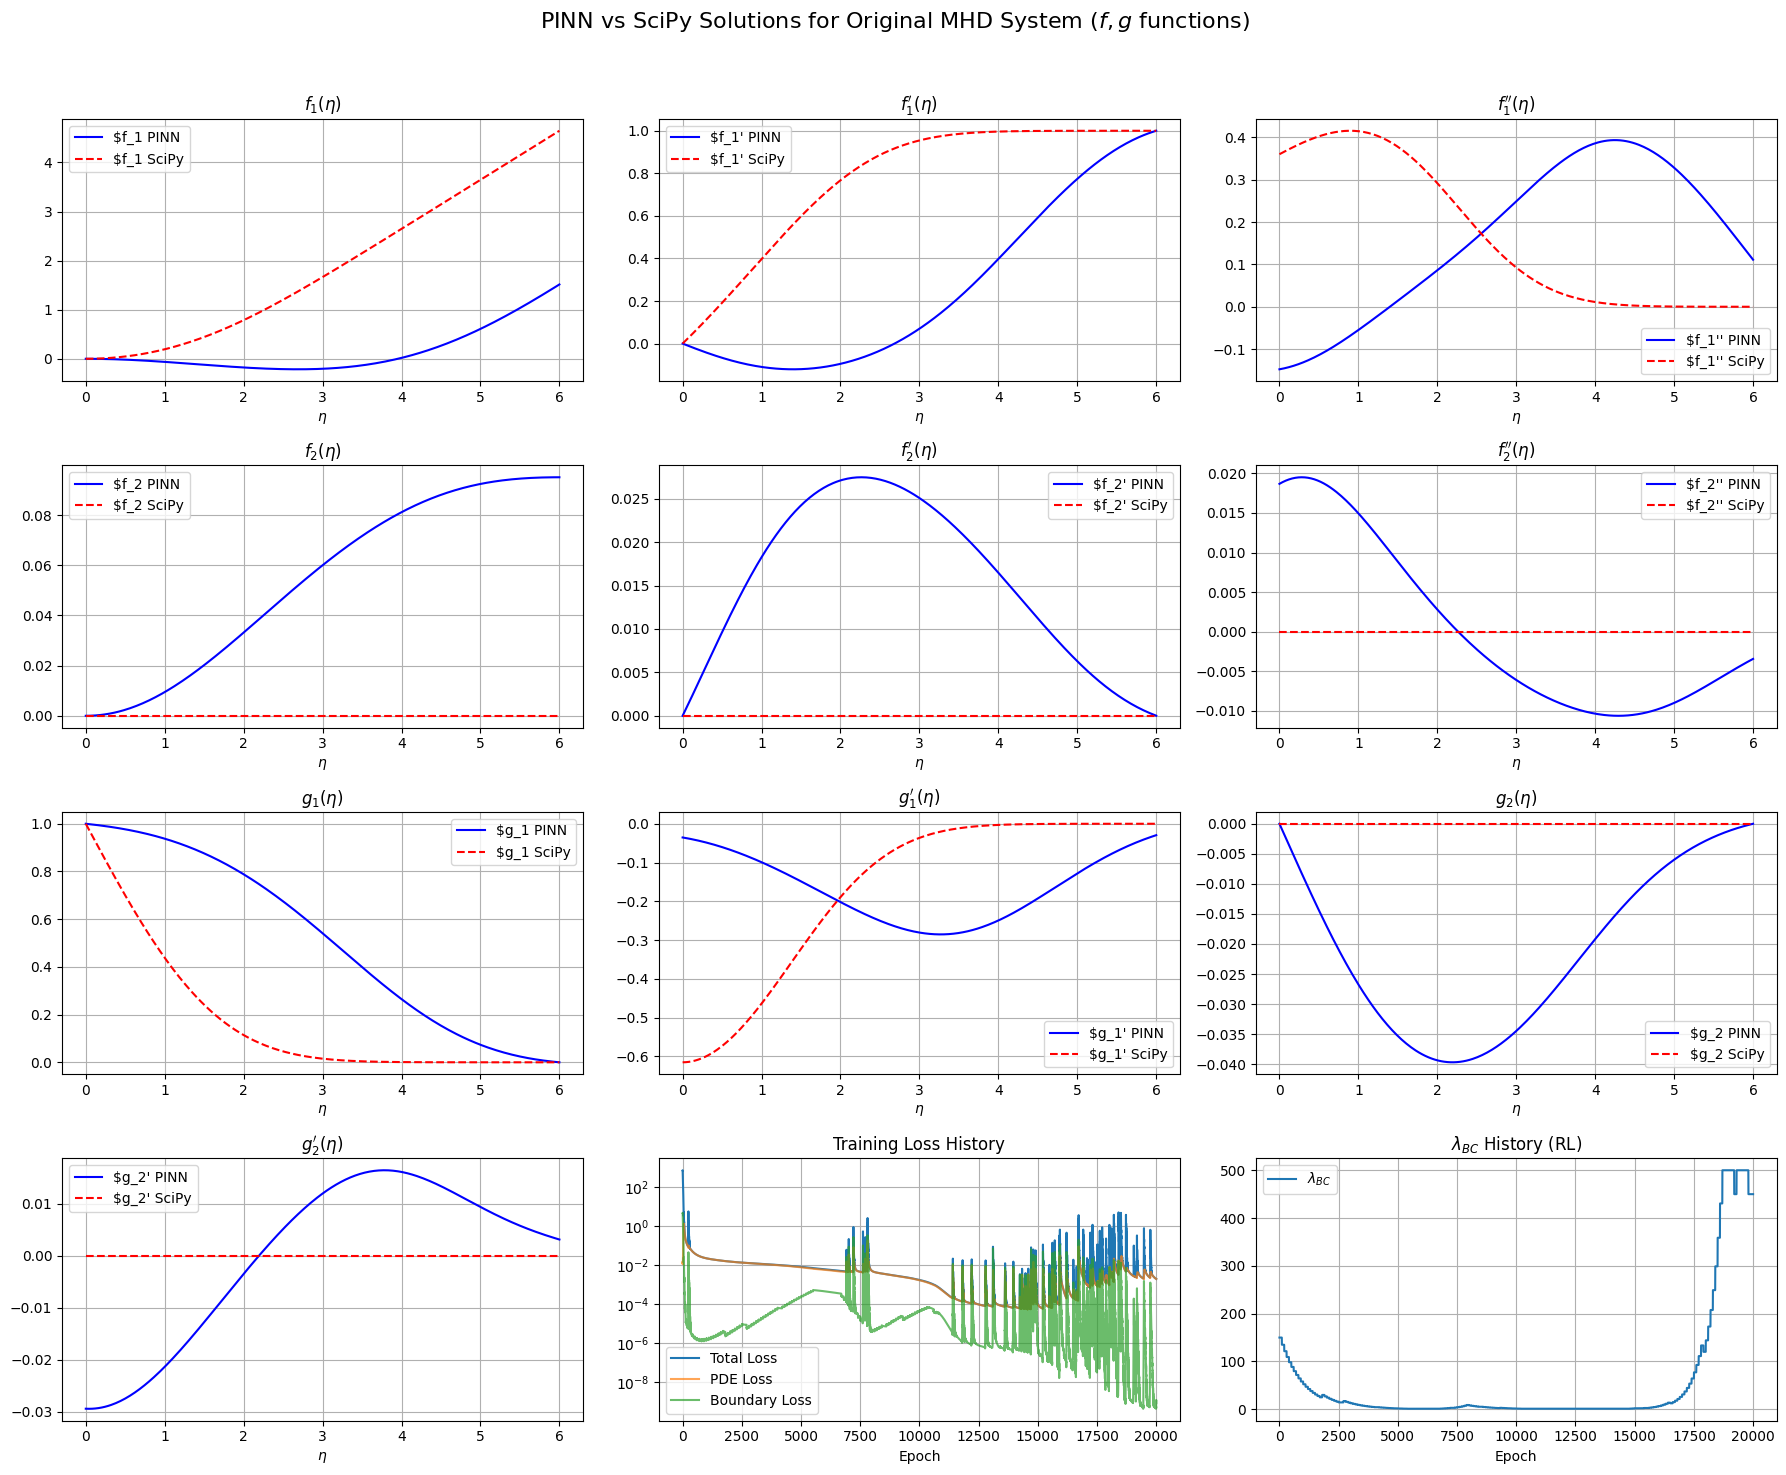

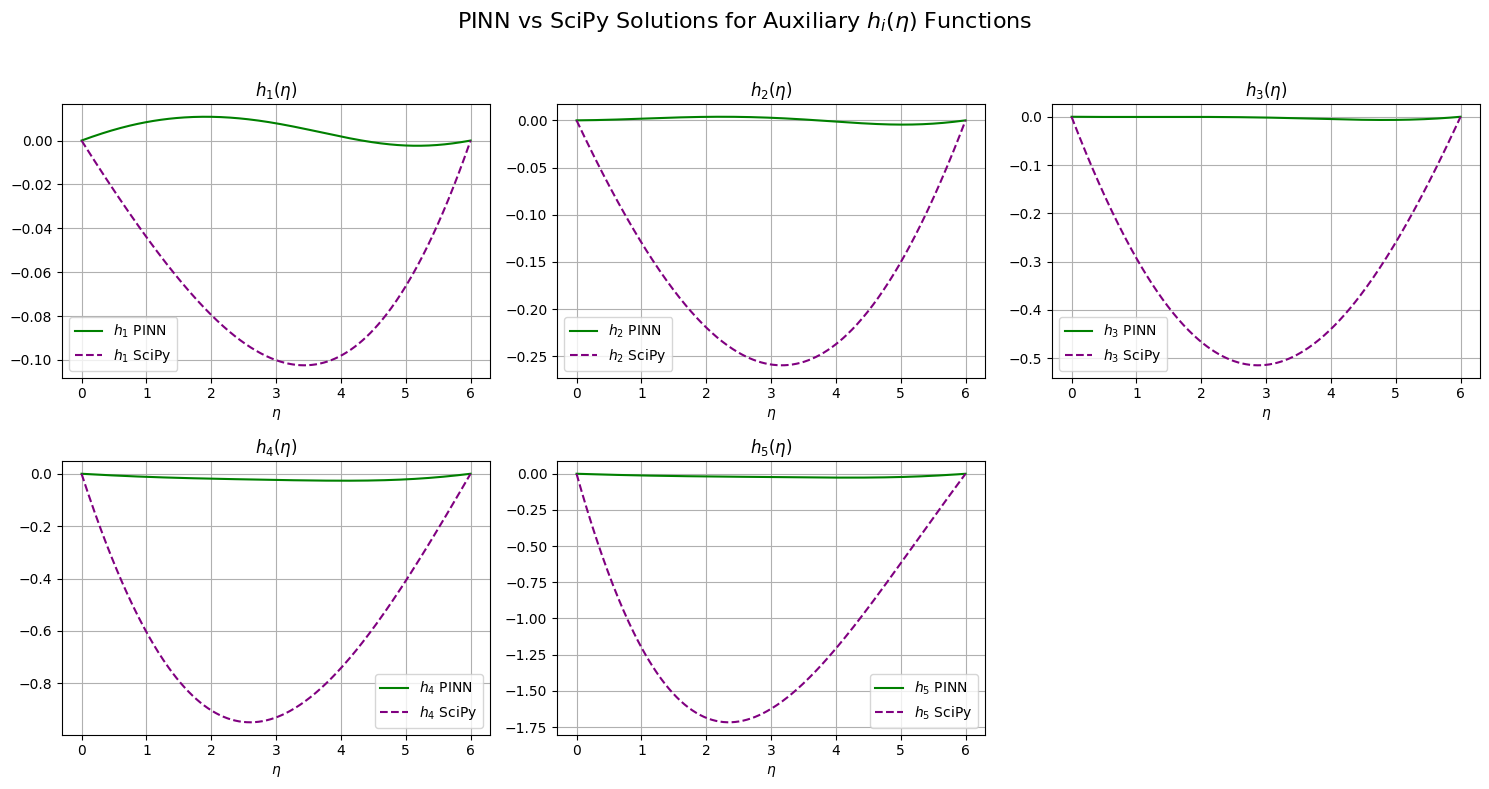

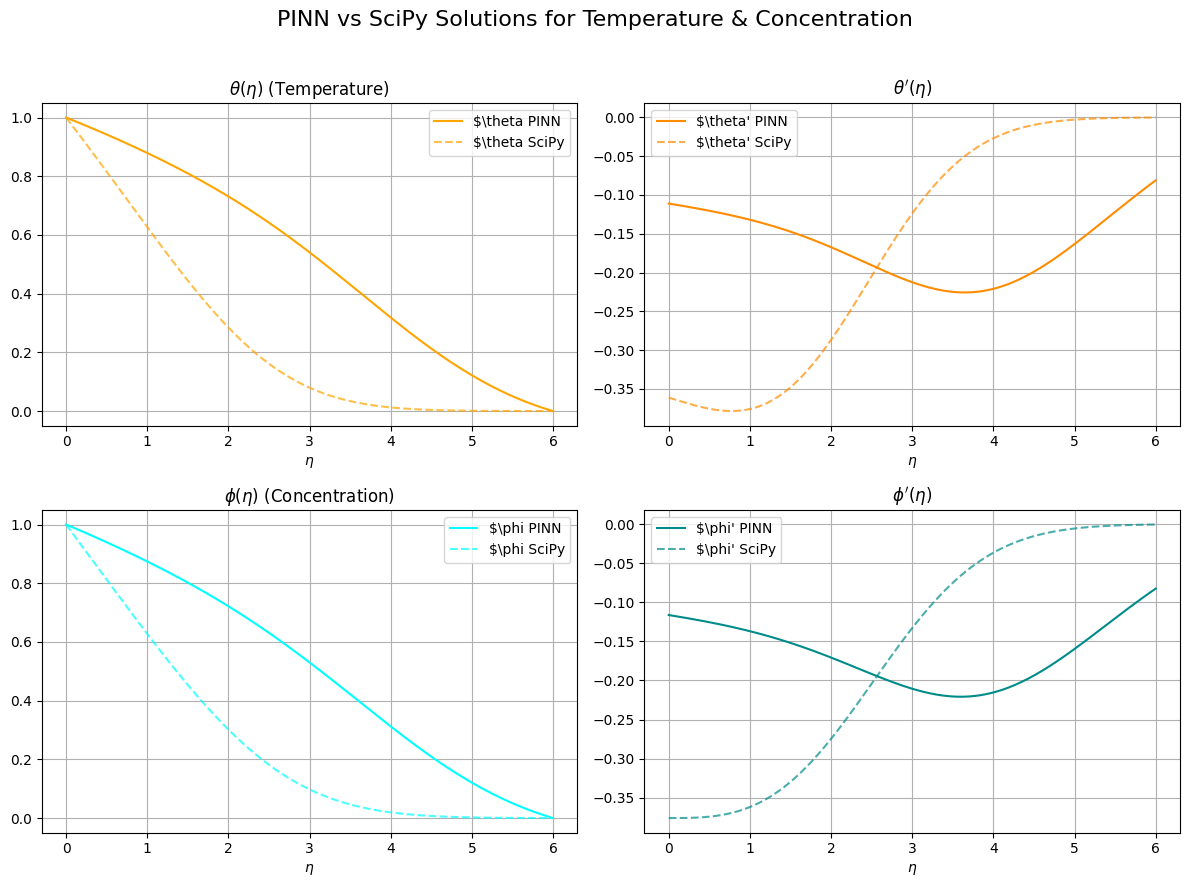


--- Final Loss Metrics (Epoch 20000) ---
Total Loss: 1.9420e-03, PDE: 1.9416e-03, Boundary: 8.7648e-10
Combined IC Loss: 5.1883e-10, Combined BC_FF Loss: 3.5765e-10
Final lambda_boundary_conditions: 450.00

--- Comparison with SciPy BVP Solver (The algorithm converged to the desired accuracy.) ---
MSE for f1(eta): 4.2551e+00
MSE for f1'(eta): 3.6427e-01
MSE for f1''(eta): 1.1368e-01
MSE for f2(eta): 4.0725e-03
MSE for f2'(eta): 3.3330e-04
MSE for f2''(eta): 1.1009e-04
MSE for g1(eta): 1.7529e-01
MSE for g1'(eta): 7.2844e-02
MSE for g2(eta): 6.4075e-04
MSE for g2'(eta): 2.3487e-04
MSE for h_1(eta): 6.0892e-03
MSE for h_2(eta): 3.5298e-02
MSE for h_3(eta): 1.3599e-01
MSE for h_4(eta): 4.3525e-01
MSE for h_5(eta): 1.4149e+00
MSE for theta(eta): 9.7061e-02
MSE for theta'(eta): 3.0238e-02
MSE for phi(eta): 8.7077e-02
MSE for phi'(eta): 2.6799e-02

Overall Average MSE (PINN vs SciPy for available solutions): 3.8186e-01

Core NN for large system saved to extended_mhd_pinn_rl_model_large_syst

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
import collections # For Q-table using defaultdict
import datetime # For timestamp

# Suppress TensorFlow warnings for cleaner output
import logging
tf.get_logger().setLevel(logging.ERROR)

# --- 0. Timestamp and Info ---
print(f"Code execution started at: {datetime.datetime.now()}")
print(f"TensorFlow version: {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.experimental.list_physical_devices('GPU'))}")

# --- 1. Define MHD Parameters and Domain ---
# Original Physical Parameters
M1 = 1.0
K1 = 0.1
M2 = 0.5
K2 = 0.1
Pr_m = 1.0 # Magnetic Prandtl number
S_w = 0.0  # << Ensures f2 and derivatives should be 0 if other conditions met
W_m = 0.0  # << Ensures g2 and derivatives should be 0 if other conditions met
ETA_MAX = 6.0

# New Physical Parameters for Energy and Concentration Equations
Pr = 0.71  # Prandtl number (for temperature)
Ec = 0.1   # Eckert number (for temperature)
M_H = 0.5  # Magnetic parameter in energy equation
Sc = 0.6   # Schmidt number (for concentration)

# Parameters for new placeholder h_i equations
num_h_equations = 5 # Restored to user's original value
A_coeffs = [0.1 * (i+1) for i in range(num_h_equations)]
B_coeffs = [0.05 * (i+1) for i in range(num_h_equations)]
C_coeffs = [0.01 * (i+1) for i in range(num_h_equations)]
# BCs for h_i: h_i(0) = 0, h_i(ETA_MAX) = 0

num_additional_odes = 2 # For theta (temperature) and phi (concentration)
total_pinn_outputs = 4 + num_h_equations + num_additional_odes

# --- 2. Define the Neural Network Architecture ---
def create_pinn_model(num_outputs, num_hidden_layers=6, num_neurons_per_layer=128): # Restored to larger network
    eta_input = tf.keras.Input(shape=(1,), name="eta")
    x = eta_input
    for _ in range(num_hidden_layers):
        x = tf.keras.layers.Dense(num_neurons_per_layer, activation="tanh")(x)
    outputs_list = [tf.keras.layers.Dense(1, name=f"out_{i+1}", activation='linear')(x) for i in range(num_outputs)]
    return tf.keras.Model(inputs=eta_input, outputs=outputs_list)

# --- 3. Define the PINN Model (subclassing tf.keras.Model) ---
class Extended_MHD_PINN_System(tf.keras.Model):
    def __init__(self, nn_approximator, params, eta_max_val, initial_lambda_bc_total=10.0, **kwargs): # initial_lambda_bc_total default value, will be overridden
        super().__init__(**kwargs)
        self.nn = nn_approximator
        self.M1 = tf.constant(params['M1'], dtype=tf.float32)
        self.K1 = tf.constant(params['K1'], dtype=tf.float32)
        self.M2 = tf.constant(params['M2'], dtype=tf.float32)
        self.K2 = tf.constant(params['K2'], dtype=tf.float32)
        self.Pr_m = tf.constant(params['Pr_m'], dtype=tf.float32)
        self.S_w = tf.constant(params['S_w'], dtype=tf.float32)
        self.W_m = tf.constant(params['W_m'], dtype=tf.float32)

        self.A_coeffs = [tf.constant(c, dtype=tf.float32) for c in params['A_coeffs']]
        self.B_coeffs = [tf.constant(c, dtype=tf.float32) for c in params['B_coeffs']]
        self.C_coeffs = [tf.constant(c, dtype=tf.float32) for c in params['C_coeffs']]
        self.num_h_eqs = params['num_h_equations']

        self.Pr = tf.constant(params['Pr'], dtype=tf.float32)
        self.Ec = tf.constant(params['Ec'], dtype=tf.float32)
        self.M_H = tf.constant(params['M_H'], dtype=tf.float32)
        self.Sc = tf.constant(params['Sc'], dtype=tf.float32)
        self.num_add_odes = params['num_additional_odes']

        self.eta_max = tf.constant(eta_max_val, dtype=tf.float32)
        self.lambda_pde = tf.constant(1.0, dtype=tf.float32)
        self.lambda_boundary_conditions = tf.Variable(initial_lambda_bc_total, dtype=tf.float32, trainable=False, name="lambda_boundary_conditions")

    def set_lambda_boundary_conditions(self, new_lambda_value):
        self.lambda_boundary_conditions.assign(np.clip(new_lambda_value, 1.0, 500.0)) # Increased max clip for lambda

    def call(self, eta):
        return self.nn(eta)

    @tf.function
    def compute_derivatives_and_residuals(self, eta_collocation):
        with tf.GradientTape(persistent=True) as tape_master:
            tape_master.watch(eta_collocation)
            with tf.GradientTape(persistent=True) as tape_child:
                tape_child.watch(eta_collocation)
                with tf.GradientTape(persistent=True) as tape_grandchild:
                    tape_grandchild.watch(eta_collocation)
                    predictions = self.nn(eta_collocation)

                    f1_pred = predictions[0]
                    f2_pred = predictions[1]
                    g1_pred = predictions[2]
                    g2_pred = predictions[3]

                    h_preds_start_idx = 4
                    h_preds = predictions[h_preds_start_idx : h_preds_start_idx + self.num_h_eqs]

                    add_odes_start_idx = h_preds_start_idx + self.num_h_eqs
                    theta_pred = predictions[add_odes_start_idx]
                    phi_pred = predictions[add_odes_start_idx + 1]

                    df1_deta = tape_grandchild.gradient(f1_pred, eta_collocation)
                    df2_deta = tape_grandchild.gradient(f2_pred, eta_collocation)
                    dg1_deta = tape_grandchild.gradient(g1_pred, eta_collocation)
                    dg2_deta = tape_grandchild.gradient(g2_pred, eta_collocation)
                    dh_deta_list = [tape_grandchild.gradient(h_pred, eta_collocation) for h_pred in h_preds] if self.num_h_eqs > 0 else []
                    dtheta_deta = tape_grandchild.gradient(theta_pred, eta_collocation)
                    dphi_deta = tape_grandchild.gradient(phi_pred, eta_collocation)
                del tape_grandchild

                df1_deta2 = tape_child.gradient(df1_deta, eta_collocation)
                df2_deta2 = tape_child.gradient(df2_deta, eta_collocation)
                dg1_deta2 = tape_child.gradient(dg1_deta, eta_collocation)
                dg2_deta2 = tape_child.gradient(dg2_deta, eta_collocation)
                dh_deta2_list = [tape_child.gradient(dh_deta, eta_collocation) for dh_deta in dh_deta_list] if self.num_h_eqs > 0 else []
                dtheta_deta2 = tape_child.gradient(dtheta_deta, eta_collocation)
                dphi_deta2 = tape_child.gradient(dphi_deta, eta_collocation)
            del tape_child

            df1_deta3 = tape_master.gradient(df1_deta2, eta_collocation)
            df2_deta3 = tape_master.gradient(df2_deta2, eta_collocation)
        del tape_master

        f1, f1_p, f1_pp, f1_ppp = f1_pred, df1_deta, df1_deta2, df1_deta3
        f2, f2_p, f2_pp, f2_ppp = f2_pred, df2_deta, df2_deta2, df2_deta3
        g1, g1_p, g1_pp = g1_pred, dg1_deta, dg1_deta2
        g2, g2_p, g2_pp = g2_pred, dg2_deta, dg2_deta2
        theta, theta_p, theta_pp = theta_pred, dtheta_deta, dtheta_deta2
        phi, phi_p, phi_pp = phi_pred, dphi_deta, dphi_deta2

        residual_f1 = f1_ppp + f1 * f1_pp - self.M1 * f2_p * g1 + self.K1 * (f1_p - 1.0)
        residual_f2 = f2_ppp + f1 * f2_pp - f1_p * f2_p + self.M2 * f1_p * g2 + self.K2 * f2_p
        residual_g1 = g1_pp + self.Pr_m * (f1 * g1_p - f1_p * g1)
        residual_g2 = g2_pp + self.Pr_m * (f1 * g2_p - f2_p * g1)
        all_residuals = [residual_f1, residual_f2, residual_g1, residual_g2]

        for i in range(self.num_h_eqs):
            h_i, h_i_p, h_i_pp = h_preds[i], dh_deta_list[i], dh_deta2_list[i]
            res_h_i = h_i_pp + self.A_coeffs[i] * h_i_p + self.B_coeffs[i] * h_i - self.C_coeffs[i] * f1_pred
            all_residuals.append(res_h_i)

        residual_theta = theta_pp + self.Pr * f1 * theta_p + self.Ec * (tf.square(f1_pp) + self.M_H * (tf.square(g1_p) + tf.square(g2_p)))
        residual_phi = phi_pp + self.Sc * f1 * phi_p
        all_residuals.extend([residual_theta, residual_phi])

        return all_residuals

    @tf.function
    def loss_fn(self, eta_collocation, eta_boundary_0, eta_boundary_max):
        all_residuals_calculated = self.compute_derivatives_and_residuals(eta_collocation)
        total_loss_pde = tf.add_n([tf.reduce_mean(tf.square(res)) for res in all_residuals_calculated])

        preds_at_0 = self.nn(eta_boundary_0)
        f1_at_0 = preds_at_0[0]
        f2_at_0 = preds_at_0[1]
        g1_at_0 = preds_at_0[2]
        g2_at_0 = preds_at_0[3]
        h_preds_start_idx = 4
        h_at_0_list = preds_at_0[h_preds_start_idx : h_preds_start_idx + self.num_h_eqs] if self.num_h_eqs > 0 else []
        add_odes_start_idx = h_preds_start_idx + self.num_h_eqs
        theta_at_0 = preds_at_0[add_odes_start_idx]
        phi_at_0 = preds_at_0[add_odes_start_idx + 1]

        with tf.GradientTape(persistent=True) as tape_ic:
            tape_ic.watch(eta_boundary_0)
            f1_ic_tape, f2_ic_tape = self.nn(eta_boundary_0)[0:2]
        f1_prime_at_0 = tape_ic.gradient(f1_ic_tape, eta_boundary_0)
        f2_prime_at_0 = tape_ic.gradient(f2_ic_tape, eta_boundary_0)
        del tape_ic

        loss_ic_fg = (tf.reduce_mean(tf.square(f1_at_0 - 0.0)) +
                      tf.reduce_mean(tf.square(f1_prime_at_0 - 0.0)) +
                      tf.reduce_mean(tf.square(f2_at_0 - 0.0)) +
                      tf.reduce_mean(tf.square(f2_prime_at_0 - self.S_w)) +
                      tf.reduce_mean(tf.square(g1_at_0 - 1.0)) +
                      tf.reduce_mean(tf.square(g2_at_0 - self.W_m)))

        preds_at_max = self.nn(eta_boundary_max)
        g1_at_max = preds_at_max[2]
        g2_at_max = preds_at_max[3]
        h_at_max_list = preds_at_max[h_preds_start_idx : h_preds_start_idx + self.num_h_eqs] if self.num_h_eqs > 0 else []
        theta_at_max = preds_at_max[add_odes_start_idx]
        phi_at_max = preds_at_max[add_odes_start_idx + 1]

        with tf.GradientTape(persistent=True) as tape_bc_max:
            tape_bc_max.watch(eta_boundary_max)
            f1_bc_tape, f2_bc_tape = self.nn(eta_boundary_max)[0:2]
        f1_prime_at_max = tape_bc_max.gradient(f1_bc_tape, eta_boundary_max)
        f2_prime_at_max = tape_bc_max.gradient(f2_bc_tape, eta_boundary_max)
        del tape_bc_max

        loss_bc_ff_fg = (tf.reduce_mean(tf.square(f1_prime_at_max - 1.0)) +
                         tf.reduce_mean(tf.square(f2_prime_at_max - 0.0)) +
                         tf.reduce_mean(tf.square(g1_at_max - 0.0)) +
                         tf.reduce_mean(tf.square(g2_at_max - 0.0)))

        loss_bc_h_at_0 = tf.add_n([tf.reduce_mean(tf.square(h_at_0_list[i] - 0.0))
                                   for i in range(self.num_h_eqs)]) if self.num_h_eqs > 0 else tf.constant(0.0, dtype=tf.float32)
        loss_bc_h_at_max = tf.add_n([tf.reduce_mean(tf.square(h_at_max_list[i] - 0.0))
                                     for i in range(self.num_h_eqs)]) if self.num_h_eqs > 0 else tf.constant(0.0, dtype=tf.float32)
        loss_bc_h_total = loss_bc_h_at_0 + loss_bc_h_at_max

        loss_ic_thermo = (tf.reduce_mean(tf.square(theta_at_0 - 1.0)) +
                          tf.reduce_mean(tf.square(phi_at_0 - 1.0)))
        loss_bc_ff_thermo = (tf.reduce_mean(tf.square(theta_at_max - 0.0)) +
                             tf.reduce_mean(tf.square(phi_at_max - 0.0)))

        total_loss_boundary = loss_ic_fg + loss_bc_ff_fg + loss_bc_h_total + loss_ic_thermo + loss_bc_ff_thermo

        loss_ic_total_combined = loss_ic_fg + loss_bc_h_at_0 + loss_ic_thermo
        loss_bc_far_field_total_combined = loss_bc_ff_fg + loss_bc_h_at_max + loss_bc_ff_thermo

        total_loss = self.lambda_pde * total_loss_pde + self.lambda_boundary_conditions * total_loss_boundary
        return total_loss, total_loss_pde, total_loss_boundary, loss_ic_total_combined, loss_bc_far_field_total_combined

    @tf.function
    def gradient_update_step(self, optimizer, eta_collocation, eta_boundary_0, eta_boundary_max):
        with tf.GradientTape() as tape:
            total_loss, loss_pde, loss_boundary, loss_ic, loss_bc_ff = self.loss_fn(
                eta_collocation, eta_boundary_0, eta_boundary_max)
        gradients = tape.gradient(total_loss, self.nn.trainable_variables)
        # Optional: Gradient clipping if exploding gradients are suspected (uncomment if needed)
        # gradients = [(tf.clip_by_value(grad, -1.0, 1.0)) if grad is not None else None for grad in gradients]
        optimizer.apply_gradients(zip(gradients, self.nn.trainable_variables))
        return total_loss, loss_pde, loss_boundary, loss_ic, loss_bc_ff

# --- 4. Q-Learning Agent ---
class QLearningAgent:
    def __init__(self, actions, learning_rate=0.1, discount_factor=0.9, exploration_rate=0.1):
        self.actions = actions; self.lr = learning_rate; self.gamma = discount_factor
        self.epsilon = exploration_rate; self.q_table = collections.defaultdict(lambda: np.zeros(len(actions)))

    def get_state(self, pde_loss, boundary_loss, epoch, total_epochs): # Revised logic
        # Handle potential zero losses to prevent division by zero or NaN
        if pde_loss < 1e-12 and boundary_loss < 1e-12: # Both effectively zero
            ratio_discrete = 1 # Balanced (both minimal)
        elif pde_loss < 1e-12: # PDE effectively zero, BC is not (BC dominant)
            ratio_discrete = 2
        elif boundary_loss < 1e-12: # BC effectively zero, PDE is not (PDE dominant)
            ratio_discrete = 0
        else:
            ratio = boundary_loss / pde_loss
            if ratio < 0.5:       # Boundary loss is significantly smaller than PDE loss (PDE dominant)
                ratio_discrete = 0
            elif ratio > 5.0:     # Boundary loss is significantly larger than PDE loss (BC dominant)
                ratio_discrete = 2
            else:                 # Losses are somewhat balanced
                ratio_discrete = 1

        if epoch < total_epochs / 3: phase = 0
        elif epoch < 2 * total_epochs / 3: phase = 1
        else: phase = 2
        return (ratio_discrete, phase)

    def choose_action(self, state):
        if np.random.rand() < self.epsilon: return np.random.choice(len(self.actions))
        else: return np.argmax(self.q_table[state])

    def update_q_table(self, state, action_idx, reward, next_state):
        old_q_value = self.q_table[state][action_idx]
        future_q_value = np.max(self.q_table[next_state])
        new_q_value = old_q_value + self.lr * (reward + self.gamma * future_q_value - old_q_value)
        self.q_table[state][action_idx] = new_q_value

# --- 5. Generate Training Data ---
N_collocation = 5000; N_boundary = 400 # Slightly increased collocation points
eta_col_np = np.random.uniform(1e-5, ETA_MAX - 1e-5, (N_collocation, 1)).astype(np.float32)
# Add more points near boundaries for better BC enforcement
eta_near_zero = np.random.uniform(1e-5, ETA_MAX * 0.1, (N_collocation // 10, 1)).astype(np.float32)
eta_near_max = np.random.uniform(ETA_MAX * 0.9, ETA_MAX - 1e-5, (N_collocation // 10, 1)).astype(np.float32)
eta_col_np = np.vstack((eta_col_np, eta_near_zero, eta_near_max))


eta_b0_np = np.full((N_boundary, 1), 0.0, dtype=np.float32)
eta_b_max_np = np.full((N_boundary, 1), ETA_MAX, dtype=np.float32)
eta_col = tf.constant(eta_col_np); eta_b0 = tf.constant(eta_b0_np); eta_b_max = tf.constant(eta_b_max_np)

# --- 6. Training the PINN with RL Agent ---
all_params = {
    'M1': M1, 'K1': K1, 'M2': M2, 'K2': K2, 'Pr_m': Pr_m, 'S_w': S_w, 'W_m': W_m,
    'Pr': Pr, 'Ec': Ec, 'M_H': M_H, 'Sc': Sc,
    'A_coeffs': A_coeffs, 'B_coeffs': B_coeffs, 'C_coeffs': C_coeffs,
    'num_h_equations': num_h_equations,
    'num_additional_odes': num_additional_odes
}
nn_core_model_large = create_pinn_model(num_outputs=total_pinn_outputs, num_hidden_layers=6, num_neurons_per_layer=128)

initial_lambda_bc_total_val = 150.0 # Increased initial lambda for BC
pinn_solver = Extended_MHD_PINN_System(nn_core_model_large, all_params, ETA_MAX, initial_lambda_bc_total=initial_lambda_bc_total_val)

initial_learning_rate = 7e-4 # Slightly adjusted
lr_schedule_obj = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=2500, decay_rate=0.9, staircase=True # Adjusted decay steps
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule_obj)

epochs = 20000 # Increased epochs for potentially harder problem
print_interval = 1000; rl_update_interval = 100
lambda_actions_multipliers = [0.9, 1.0, 1.2] # Skewed to favor increase/maintain lambda_BC
rl_agent = QLearningAgent(actions=lambda_actions_multipliers, exploration_rate=0.2, learning_rate=0.1) # Slightly reduced exploration

print(f"Starting PINN training for {epochs} epochs for a {total_pinn_outputs}-output system.")
history_loss_total, history_loss_pde, history_loss_boundary = [], [], []
history_loss_ic_combined, history_loss_bc_ff_combined, history_lambda_bc_total = [], [], []

total_loss_val, loss_pde_val, loss_boundary_val, loss_ic_val, loss_bc_ff_val = pinn_solver.gradient_update_step(optimizer, eta_col, eta_b0, eta_b_max)
history_loss_total.append(total_loss_val.numpy())
history_loss_pde.append(loss_pde_val.numpy())
history_loss_boundary.append(loss_boundary_val.numpy())
history_loss_ic_combined.append(loss_ic_val.numpy())
history_loss_bc_ff_combined.append(loss_bc_ff_val.numpy())
history_lambda_bc_total.append(pinn_solver.lambda_boundary_conditions.numpy())

if epochs > 0:
      print(f"Epoch {1}/{epochs} - Total Loss: {history_loss_total[0]:.3e}, PDE: {history_loss_pde[0]:.3e}, Bound: {history_loss_boundary[0]:.3e} (IC_sum: {history_loss_ic_combined[0]:.3e}, BC_FF_sum: {history_loss_bc_ff_combined[0]:.3e}), lambda_BC: {history_lambda_bc_total[0]:.2f}, LR: {lr_schedule_obj(optimizer.iterations).numpy():.1e}")

for epoch in range(1, epochs):
    current_lambda_val = pinn_solver.lambda_boundary_conditions.numpy()
    if epoch % rl_update_interval == 0 and epoch > 0: # Ensure history has values for state
        state = rl_agent.get_state(history_loss_pde[-1], history_loss_boundary[-1], epoch, epochs)
        action_idx = rl_agent.choose_action(state)
        multiplier = rl_agent.actions[action_idx]
        new_lambda_val = current_lambda_val * multiplier
        pinn_solver.set_lambda_boundary_conditions(new_lambda_val)
        current_lambda_for_history = pinn_solver.lambda_boundary_conditions.numpy() # lambda that will be used
    else:
        current_lambda_for_history = current_lambda_val

    total_loss_val, loss_pde_val, loss_boundary_val, loss_ic_val, loss_bc_ff_val = pinn_solver.gradient_update_step(optimizer, eta_col, eta_b0, eta_b_max)

    if epoch % rl_update_interval == 0 and epoch > 0:
        # Reward based on change in total loss over the rl_update_interval
        # Ensure enough history exists for this comparison
        if len(history_loss_total) >= rl_update_interval:
             reward = -(total_loss_val.numpy() - history_loss_total[-rl_update_interval])
        else: # Fallback for early updates
             reward = -(total_loss_val.numpy() - history_loss_total[-1])

        next_state = rl_agent.get_state(loss_pde_val.numpy(), loss_boundary_val.numpy(), epoch + 1, epochs)
        rl_agent.update_q_table(state, action_idx, reward, next_state)

    history_loss_total.append(total_loss_val.numpy())
    history_loss_pde.append(loss_pde_val.numpy())
    history_loss_boundary.append(loss_boundary_val.numpy())
    history_loss_ic_combined.append(loss_ic_val.numpy())
    history_loss_bc_ff_combined.append(loss_bc_ff_val.numpy())
    history_lambda_bc_total.append(current_lambda_for_history)

    if (epoch + 1) % print_interval == 0:
        print(f"Epoch {epoch+1}/{epochs} - Total Loss: {total_loss_val:.3e}, PDE: {loss_pde_val:.3e}, Bound: {loss_boundary_val:.3e} (IC_sum: {loss_ic_val:.3e}, BC_FF_sum: {loss_bc_ff_val:.3e}), lambda_BC: {current_lambda_for_history:.2f}, LR: {lr_schedule_obj(optimizer.iterations).numpy():.1e}")
print("Training finished.")

# --- 7. Prediction and Plotting --- (Plotting remains the same)
print("\nGenerating predictions and plots for the extended system...")
eta_plot_np = np.linspace(0, ETA_MAX, 300).reshape(-1, 1).astype(np.float32)
eta_plot_tf = tf.constant(eta_plot_np)
all_pinn_preds_tf = pinn_solver.nn(eta_plot_tf)
all_pinn_preds_np = [pred.numpy().flatten() for pred in all_pinn_preds_tf]

f1_pinn = all_pinn_preds_np[0]
f2_pinn = all_pinn_preds_np[1]
g1_pinn = all_pinn_preds_np[2]
g2_pinn = all_pinn_preds_np[3]

h_preds_start_idx = 4
h_pinn_list = all_pinn_preds_np[h_preds_start_idx : h_preds_start_idx + num_h_equations] if num_h_equations > 0 else []

add_odes_start_idx = h_preds_start_idx + num_h_equations
theta_pinn = all_pinn_preds_np[add_odes_start_idx]
phi_pinn = all_pinn_preds_np[add_odes_start_idx + 1]

with tf.GradientTape(persistent=True) as tape_plot2:
    tape_plot2.watch(eta_plot_tf)
    with tf.GradientTape(persistent=True) as tape_plot1:
        tape_plot1.watch(eta_plot_tf)
        nn_outputs_for_plot = pinn_solver.nn(eta_plot_tf)
        f1_plot = nn_outputs_for_plot[0]
        f2_plot = nn_outputs_for_plot[1]
        g1_plot = nn_outputs_for_plot[2]
        g2_plot = nn_outputs_for_plot[3]
        theta_plot = nn_outputs_for_plot[add_odes_start_idx]
        phi_plot = nn_outputs_for_plot[add_odes_start_idx + 1]

    df1_deta_plot = tape_plot1.gradient(f1_plot, eta_plot_tf)
    df2_deta_plot = tape_plot1.gradient(f2_plot, eta_plot_tf)
    dg1_deta_plot = tape_plot1.gradient(g1_plot, eta_plot_tf)
    dg2_deta_plot = tape_plot1.gradient(g2_plot, eta_plot_tf)
    dtheta_deta_plot = tape_plot1.gradient(theta_plot, eta_plot_tf)
    dphi_deta_plot = tape_plot1.gradient(phi_plot, eta_plot_tf)
del tape_plot1

df1_deta2_plot = tape_plot2.gradient(df1_deta_plot, eta_plot_tf)
df2_deta2_plot = tape_plot2.gradient(df2_deta_plot, eta_plot_tf)
del tape_plot2

f1_prime_pinn = df1_deta_plot.numpy().flatten()
f1_prime_prime_pinn = df1_deta2_plot.numpy().flatten()
f2_prime_pinn = df2_deta_plot.numpy().flatten()
f2_prime_prime_pinn = df2_deta2_plot.numpy().flatten()
g1_prime_pinn = dg1_deta_plot.numpy().flatten()
g2_prime_pinn = dg2_deta_plot.numpy().flatten()
theta_prime_pinn = dtheta_deta_plot.numpy().flatten()
phi_prime_pinn = dphi_deta_plot.numpy().flatten()

def extended_mhd_system_scipy(eta, y_vec, params):
    M1_s, K1_s, M2_s, K2_s, Pr_m_s = params['M1'], params['K1'], params['M2'], params['K2'], params['Pr_m']
    Pr_s, Ec_s, M_H_s, Sc_s = params['Pr'], params['Ec'], params['M_H'], params['Sc']
    A_s, B_s, C_s = params['A_coeffs'], params['B_coeffs'], params['C_coeffs']
    n_h_eqs = params['num_h_equations']

    f1, f1p, f1pp = y_vec[0], y_vec[1], y_vec[2]
    f2, f2p, f2pp = y_vec[3], y_vec[4], y_vec[5]
    g1, g1p = y_vec[6], y_vec[7]
    g2, g2p = y_vec[8], y_vec[9]

    derivs = np.zeros_like(y_vec)
    derivs[0] = f1p
    derivs[1] = f1pp
    derivs[2] = -f1*f1pp + M1_s*f2p*g1 - K1_s*(f1p-1.0)
    derivs[3] = f2p
    derivs[4] = f2pp
    derivs[5] = -f1*f2pp + f1p*f2p - M2_s*f1p*g2 - K2_s*f2p
    derivs[6] = g1p
    derivs[7] = -Pr_m_s*(f1*g1p - f1p*g1)
    derivs[8] = g2p
    derivs[9] = -Pr_m_s*(f1*g2p - f2p*g1)

    h_start_idx_scipy = 10
    current_f1_val_for_h_forcing = f1
    if n_h_eqs > 0:
        for i in range(n_h_eqs):
            idx_h = h_start_idx_scipy + 2*i
            idx_hp = h_start_idx_scipy + 2*i + 1
            h_i, h_ip = y_vec[idx_h], y_vec[idx_hp]
            derivs[idx_h] = h_ip
            derivs[idx_hp] = C_s[i]*current_f1_val_for_h_forcing - A_s[i]*h_ip - B_s[i]*h_i

    add_odes_start_idx_scipy = h_start_idx_scipy + 2*n_h_eqs
    theta,thetap = y_vec[add_odes_start_idx_scipy], y_vec[add_odes_start_idx_scipy+1]
    phi,phip = y_vec[add_odes_start_idx_scipy+2], y_vec[add_odes_start_idx_scipy+3]

    derivs[add_odes_start_idx_scipy] = thetap
    derivs[add_odes_start_idx_scipy+1] = -Pr_s * f1 * thetap - Ec_s * (f1pp**2 + M_H_s * (g1p**2 + g2p**2))
    derivs[add_odes_start_idx_scipy+2] = phip
    derivs[add_odes_start_idx_scipy+3] = -Sc_s * f1 * phip
    return derivs

def extended_mhd_bc_scipy(ya, yb, params):
    S_w_s,W_m_s=params['S_w'],params['W_m']
    n_h_eqs = params['num_h_equations']

    bc_original=[ ya[0]-0.0, ya[1]-0.0, yb[1]-1.0, ya[3]-0.0, ya[4]-S_w_s, yb[4]-0.0, ya[6]-1.0, yb[6]-0.0, ya[8]-W_m_s, yb[8]-0.0]

    bc_h=[]
    if n_h_eqs > 0:
        h_start_idx_scipy_bc = 10
        for i in range(n_h_eqs):
            idx_h_ya = h_start_idx_scipy_bc + 2*i
            bc_h.append(ya[idx_h_ya]-0.0)
            bc_h.append(yb[idx_h_ya]-0.0)

    add_odes_start_idx_scipy_bc = 10 + 2*n_h_eqs
    bc_additional_odes = [
        ya[add_odes_start_idx_scipy_bc] - 1.0, yb[add_odes_start_idx_scipy_bc] - 0.0,
        ya[add_odes_start_idx_scipy_bc+2] - 1.0, yb[add_odes_start_idx_scipy_bc+2] - 0.0 ]
    return np.array(bc_original + bc_h + bc_additional_odes)

eta_scipy_mesh = np.linspace(0, ETA_MAX, 200)
total_scipy_variables = 10 + 2*num_h_equations + 2*num_additional_odes
y_init_guess_extended = np.zeros((total_scipy_variables, eta_scipy_mesh.size))

y_init_guess_extended[1,:] = eta_scipy_mesh/ETA_MAX
y_init_guess_extended[0,:] = (eta_scipy_mesh**2)/(2*ETA_MAX)
y_init_guess_extended[2,:] = 1.0/ETA_MAX
if S_w != 0:
    y_init_guess_extended[4,:] = S_w*(1.0-eta_scipy_mesh/ETA_MAX)
    y_init_guess_extended[3,:] = S_w*(eta_scipy_mesh-(eta_scipy_mesh**2)/(2*ETA_MAX))
    y_init_guess_extended[5,:] = -S_w/ETA_MAX
y_init_guess_extended[6,:] = 1.0-(eta_scipy_mesh/ETA_MAX)
y_init_guess_extended[7,:] = -1.0/ETA_MAX
if W_m != 0:
    y_init_guess_extended[8,:] = W_m*(1.0-eta_scipy_mesh/ETA_MAX)
    y_init_guess_extended[9,:] = -W_m/ETA_MAX

if num_h_equations > 0:
    h_start_idx_scipy_guess = 10
    for i in range(num_h_equations):
        idx_h = h_start_idx_scipy_guess + 2*i
        idx_hp = h_start_idx_scipy_guess + 2*i + 1
        y_init_guess_extended[idx_h,:] = 0.01 * eta_scipy_mesh * (ETA_MAX - eta_scipy_mesh) / (ETA_MAX**2)
        y_init_guess_extended[idx_hp,:] = 0.01 * (ETA_MAX - 2*eta_scipy_mesh) / (ETA_MAX**2)

add_odes_start_idx_scipy_guess = 10 + 2*num_h_equations
y_init_guess_extended[add_odes_start_idx_scipy_guess, :] = 1.0 - (eta_scipy_mesh / ETA_MAX)
y_init_guess_extended[add_odes_start_idx_scipy_guess+1, :] = -1.0 / ETA_MAX
y_init_guess_extended[add_odes_start_idx_scipy_guess+2, :] = 1.0 - (eta_scipy_mesh / ETA_MAX)
y_init_guess_extended[add_odes_start_idx_scipy_guess+3, :] = -1.0 / ETA_MAX

print("Solving with SciPy BVP solver for the extended system...")
scipy_solved_extended = False; sol_scipy_message_extended = "SciPy BVP (extended) failed/not run."
f1_scipy, f1_prime_scipy, f1_pp_scipy = [None]*3
f2_scipy, f2_prime_scipy, f2_pp_scipy = [None]*3
g1_scipy, g1_prime_scipy = [None]*2
g2_scipy, g2_prime_scipy = [None]*2
h_scipy_list = [None]*num_h_equations if num_h_equations > 0 else []
theta_scipy, theta_prime_scipy = [None]*2
phi_scipy, phi_prime_scipy = [None]*2

try:
    sol_scipy_extended = solve_bvp(lambda eta,y:extended_mhd_system_scipy(eta,y,all_params),
                                   lambda ya,yb:extended_mhd_bc_scipy(ya,yb,all_params),
                                   eta_scipy_mesh, y_init_guess_extended, verbose=0, max_nodes=30000, tol=1e-5)
    sol_scipy_message_extended=sol_scipy_extended.message
    if sol_scipy_extended.success:
        print(f"SciPy BVP (extended) converged: {sol_scipy_extended.message}")
        y_scipy_plot_extended=sol_scipy_extended.sol(eta_plot_np.flatten())

        f1_scipy,f1_prime_scipy,f1_pp_scipy = y_scipy_plot_extended[0],y_scipy_plot_extended[1],y_scipy_plot_extended[2]
        f2_scipy,f2_prime_scipy,f2_pp_scipy = y_scipy_plot_extended[3],y_scipy_plot_extended[4],y_scipy_plot_extended[5]
        g1_scipy,g1_prime_scipy=y_scipy_plot_extended[6],y_scipy_plot_extended[7]
        g2_scipy,g2_prime_scipy=y_scipy_plot_extended[8],y_scipy_plot_extended[9]

        if num_h_equations > 0:
             h_scipy_list=[y_scipy_plot_extended[(10 + 2*i)] for i in range(num_h_equations)]

        idx_add_odes_plot = 10 + 2*num_h_equations
        theta_scipy = y_scipy_plot_extended[idx_add_odes_plot]
        theta_prime_scipy = y_scipy_plot_extended[idx_add_odes_plot+1]
        phi_scipy = y_scipy_plot_extended[idx_add_odes_plot+2]
        phi_prime_scipy = y_scipy_plot_extended[idx_add_odes_plot+3]
        scipy_solved_extended=True
    else: print(f"SciPy BVP (extended) FAILED: {sol_scipy_extended.message}")
except Exception as e: print(f"Error during SciPy BVP (extended) solution: {e}"); sol_scipy_message_extended=str(e)

# Plotting for f,g system
fig_fg, axs_fg = plt.subplots(4, 3, figsize=(18, 15))
axs_fg = axs_fg.flatten()
plot_titles_fg = ["$f_1(\eta)$", "$f_1'(\eta)$", "$f_1''(\eta)$",
                  "$f_2(\eta)$", "$f_2'(\eta)$", "$f_2''(\eta)$",
                  "$g_1(\eta)$", "$g_1'(\eta)$",
                  "$g_2(\eta)$", "$g_2'(\eta)$"]
pinn_data_fg = [f1_pinn, f1_prime_pinn, f1_prime_prime_pinn,
                f2_pinn, f2_prime_pinn, f2_prime_prime_pinn,
                g1_pinn, g1_prime_pinn,
                g2_pinn, g2_prime_pinn]
scipy_data_fg = [f1_scipy, f1_prime_scipy, f1_pp_scipy,
                 f2_scipy, f2_prime_scipy, f2_pp_scipy,
                 g1_scipy, g1_prime_scipy,
                 g2_scipy, g2_prime_scipy]

for i in range(10):
    axs_fg[i].plot(eta_plot_np, pinn_data_fg[i], label=f'{plot_titles_fg[i].split("(")[0]} PINN', color='blue')
    if scipy_solved_extended and scipy_data_fg[i] is not None:
        axs_fg[i].plot(eta_plot_np, scipy_data_fg[i], label=f'{plot_titles_fg[i].split("(")[0]} SciPy', ls='--', color='red')
    axs_fg[i].legend(); axs_fg[i].grid(True); axs_fg[i].set_title(plot_titles_fg[i]); axs_fg[i].set_xlabel('$\eta$')

axs_fg[10].plot(history_loss_total, label='Total Loss'); axs_fg[10].plot(history_loss_pde, label='PDE Loss', alpha=0.7)
axs_fg[10].plot(history_loss_boundary, label='Boundary Loss', alpha=0.7)
axs_fg[10].legend(); axs_fg[10].grid(True); axs_fg[10].set_yscale('log'); axs_fg[10].set_title('Training Loss History'); axs_fg[10].set_xlabel('Epoch')

axs_fg[11].plot(history_lambda_bc_total, label='$\lambda_{BC}$')
axs_fg[11].legend(); axs_fg[11].grid(True); axs_fg[11].set_title('$\lambda_{BC}$ History (RL)'); axs_fg[11].set_xlabel('Epoch')
fig_fg.suptitle('PINN vs SciPy Solutions for Original MHD System ($f, g$ functions)', fontsize=16)
fig_fg.tight_layout(rect=[0, 0, 1, 0.96]); plt.show(block=False)


if num_h_equations > 0:
    cols_h = min(num_h_equations, 3)
    rows_h = (num_h_equations + cols_h - 1) // cols_h
    fig_h, axs_h = plt.subplots(rows_h, cols_h, figsize=(cols_h * 5, rows_h * 4), squeeze=False)
    axs_h = axs_h.flatten()
    for i in range(num_h_equations):
        axs_h[i].plot(eta_plot_np, h_pinn_list[i], label=f'$h_{i+1}$ PINN', color='green')
        if scipy_solved_extended and i < len(h_scipy_list) and h_scipy_list[i] is not None:
            axs_h[i].plot(eta_plot_np, h_scipy_list[i], label=f'$h_{i+1}$ SciPy', ls='--', color='purple')
        axs_h[i].legend(); axs_h[i].grid(True); axs_h[i].set_title(f'$h_{i+1}(\eta)$'); axs_h[i].set_xlabel('$\eta$')
    for j in range(num_h_equations, rows_h * cols_h): fig_h.delaxes(axs_h[j])
    fig_h.suptitle(f'PINN vs SciPy Solutions for Auxiliary $h_i(\eta)$ Functions', fontsize=16)
    fig_h.tight_layout(rect=[0, 0, 1, 0.96]); plt.show(block=False)


if num_additional_odes > 0:
    fig_add, axs_add = plt.subplots(num_additional_odes, 2, figsize=(12, num_additional_odes * 4.5), squeeze=False)
    plot_titles_add = ["$\\theta(\eta)$ (Temperature)", "$\\theta'(\eta)$", "$\phi(\eta)$ (Concentration)", "$\phi'(\eta)$"]
    pinn_data_add = [theta_pinn, theta_prime_pinn, phi_pinn, phi_prime_pinn]
    scipy_data_add = [theta_scipy, theta_prime_scipy, phi_scipy, phi_prime_scipy]

    axs_add_flat = axs_add.flatten()
    plot_colors = ['orange', 'darkorange', 'cyan', 'darkcyan']
    for i in range(num_additional_odes * 2):
        axs_add_flat[i].plot(eta_plot_np, pinn_data_add[i], label=f'{plot_titles_add[i].split("(")[0]} PINN', color=plot_colors[i])
        if scipy_solved_extended and scipy_data_add[i] is not None:
            axs_add_flat[i].plot(eta_plot_np, scipy_data_add[i], label=f'{plot_titles_add[i].split("(")[0]} SciPy', ls='--', color=plot_colors[i], alpha=0.7)
        axs_add_flat[i].legend(); axs_add_flat[i].grid(True); axs_add_flat[i].set_title(plot_titles_add[i]); axs_add_flat[i].set_xlabel('$\eta$')

    fig_add.suptitle('PINN vs SciPy Solutions for Temperature & Concentration', fontsize=16)
    fig_add.tight_layout(rect=[0, 0, 1, 0.96]); plt.show(block=False)

plt.show() # To show all non-blocking plots

# --- 8. Accuracy Metrics ---
if history_loss_total:
    print(f"\n--- Final Loss Metrics (Epoch {len(history_loss_total)}) ---")
    print(f"Total Loss: {history_loss_total[-1]:.4e}, PDE: {history_loss_pde[-1]:.4e}, Boundary: {history_loss_boundary[-1]:.4e}")
    print(f"Combined IC Loss: {history_loss_ic_combined[-1]:.4e}, Combined BC_FF Loss: {history_loss_bc_ff_combined[-1]:.4e}")
    print(f"Final lambda_boundary_conditions: {pinn_solver.lambda_boundary_conditions.numpy():.2f}")

if scipy_solved_extended:
    all_mses_extended = []; mse_values_dict = {}
    def calculate_mse_and_log(name, pinn_data, scipy_data, mses_list, mses_dict):
        p_data = np.array(pinn_data).flatten() if pinn_data is not None else None
        s_data = np.array(scipy_data).flatten() if scipy_data is not None else None

        if p_data is None or s_data is None: return None
        if p_data.shape != s_data.shape:
            print(f"Warning: Shape mismatch for {name}. PINN:{p_data.shape}, SciPy:{s_data.shape}. Skipping MSE.")
            return None

        mse = np.mean((p_data - s_data)**2)
        mses_list.append(mse); mses_dict[name] = mse
        return mse

    print(f"\n--- Comparison with SciPy BVP Solver ({sol_scipy_message_extended}) ---")
    data_pairs = [("f1", f1_pinn, f1_scipy), ("f1'", f1_prime_pinn, f1_prime_scipy), ("f1''", f1_prime_prime_pinn, f1_pp_scipy),
                  ("f2", f2_pinn, f2_scipy), ("f2'", f2_prime_pinn, f2_prime_scipy), ("f2''", f2_prime_prime_pinn, f2_pp_scipy),
                  ("g1", g1_pinn, g1_scipy), ("g1'", g1_prime_pinn, g1_prime_scipy),
                  ("g2", g2_pinn, g2_scipy), ("g2'", g2_prime_pinn, g2_prime_scipy)]
    if num_h_equations > 0:
        for i in range(num_h_equations):
            data_pairs.append((f"h_{i+1}", h_pinn_list[i] if i < len(h_pinn_list) else None,
                                            h_scipy_list[i] if i < len(h_scipy_list) else None))
    if num_additional_odes > 0:
        data_pairs.append(("theta", theta_pinn, theta_scipy))
        data_pairs.append(("theta'", theta_prime_pinn, theta_prime_scipy))
        data_pairs.append(("phi", phi_pinn, phi_scipy))
        data_pairs.append(("phi'", phi_prime_pinn, phi_prime_scipy))

    for name,p_data,s_data in data_pairs: calculate_mse_and_log(name,p_data,s_data,all_mses_extended,mse_values_dict)
    for name,mse_val in mse_values_dict.items():
        if mse_val is not None: print(f"MSE for {name}(eta): {mse_val:.4e}")

    valid_mses = [m for m in all_mses_extended if m is not None]
    if valid_mses:
        overall_avg_mse_extended = np.mean(valid_mses)
        print(f"\nOverall Average MSE (PINN vs SciPy for available solutions): {overall_avg_mse_extended:.4e}")
    else: print("No MSE values successfully calculated.")
else: print(f"\nSciPy BVP (extended) solution not available or failed. ({sol_scipy_message_extended}). Accuracy metrics vs SciPy not computed.")

# --- 9. Save the Model ---
model_filename_large = "extended_mhd_pinn_rl_model_large_system.h5"
try:
    if not pinn_solver.nn.built:
        _ = pinn_solver.nn(tf.constant(np.zeros((1,1),dtype=np.float32)))
    pinn_solver.nn.save(model_filename_large)
    print(f"\nCore NN for large system saved to {model_filename_large}")
except Exception as e: print(f"\nError saving Keras model: {e}")

# --- 10. RL Discussion --- (RL Discussion remains the same)
print("\n--- Note on this RL Implementation ---")
print("This RL implementation for tuning lambda_BC is illustrative.")
print("Key aspects:")
print("1. State Space: Discretized ratio of Boundary_Loss/PDE_Loss and training phase (early, mid, late).")
print("2. Actions: Multiplicative adjustments to lambda_BC (e.g., 0.9x, 1.0x, 1.2x).") # Updated to reflect change
print("3. Reward: Negative change in total loss since the last RL action. Aims to decrease total loss.")
print("4. Q-Table: Stores action values for state-action pairs.")
print("Potential improvements for more advanced RL:")
print("  - More granular state space (e.g., include individual loss magnitudes, gradients of losses).")
print("  - Continuous action space (e.g., using policy gradient methods like DDPG, A2C).")
print("  - More sophisticated reward shaping (e.g., penalizing high individual losses, rewarding stability).")
print("  - Experience replay buffer for DQN-like approaches.")
print("  - Normalization of loss components in state or reward function.")
print("The current setup provides a basic framework for adaptive weighting in PINNs.")

print(f"\nCode execution finished at: {datetime.datetime.now()}")

Starting PINN training for 30000 epochs with RL-adjusted lambda_bc (Extended System)...
Epoch 1/30000 - Total Loss: 8.472e+01, ODE: 1.968e-03, BC: 2.420e+00, lambda_bc: 35.00, LR: 1.00e-03
Epoch 1000/30000 - Total Loss: 2.869e-02, ODE: 2.864e-02, BC: 2.958e-07, lambda_bc: 169.11, LR: 1.00e-03
Epoch 2000/30000 - Total Loss: 1.230e-02, ODE: 1.215e-02, BC: 1.431e-05, lambda_bc: 10.72, LR: 9.00e-04
Epoch 3000/30000 - Total Loss: 1.035e-02, ODE: 9.543e-03, BC: 8.025e-04, lambda_bc: 1.00, LR: 9.00e-04
Epoch 4000/30000 - Total Loss: 9.488e-03, ODE: 8.765e-03, BC: 7.230e-04, lambda_bc: 1.00, LR: 8.10e-04
Epoch 5000/30000 - Total Loss: 8.584e-03, ODE: 7.982e-03, BC: 6.024e-04, lambda_bc: 1.00, LR: 8.10e-04
Epoch 6000/30000 - Total Loss: 7.517e-03, ODE: 7.064e-03, BC: 4.529e-04, lambda_bc: 1.00, LR: 7.29e-04
Epoch 7000/30000 - Total Loss: 5.000e-03, ODE: 4.739e-03, BC: 2.602e-04, lambda_bc: 1.00, LR: 7.29e-04
Epoch 8000/30000 - Total Loss: 4.011e-04, ODE: 3.933e-04, BC: 7.834e-06, lambda_bc: 1.0

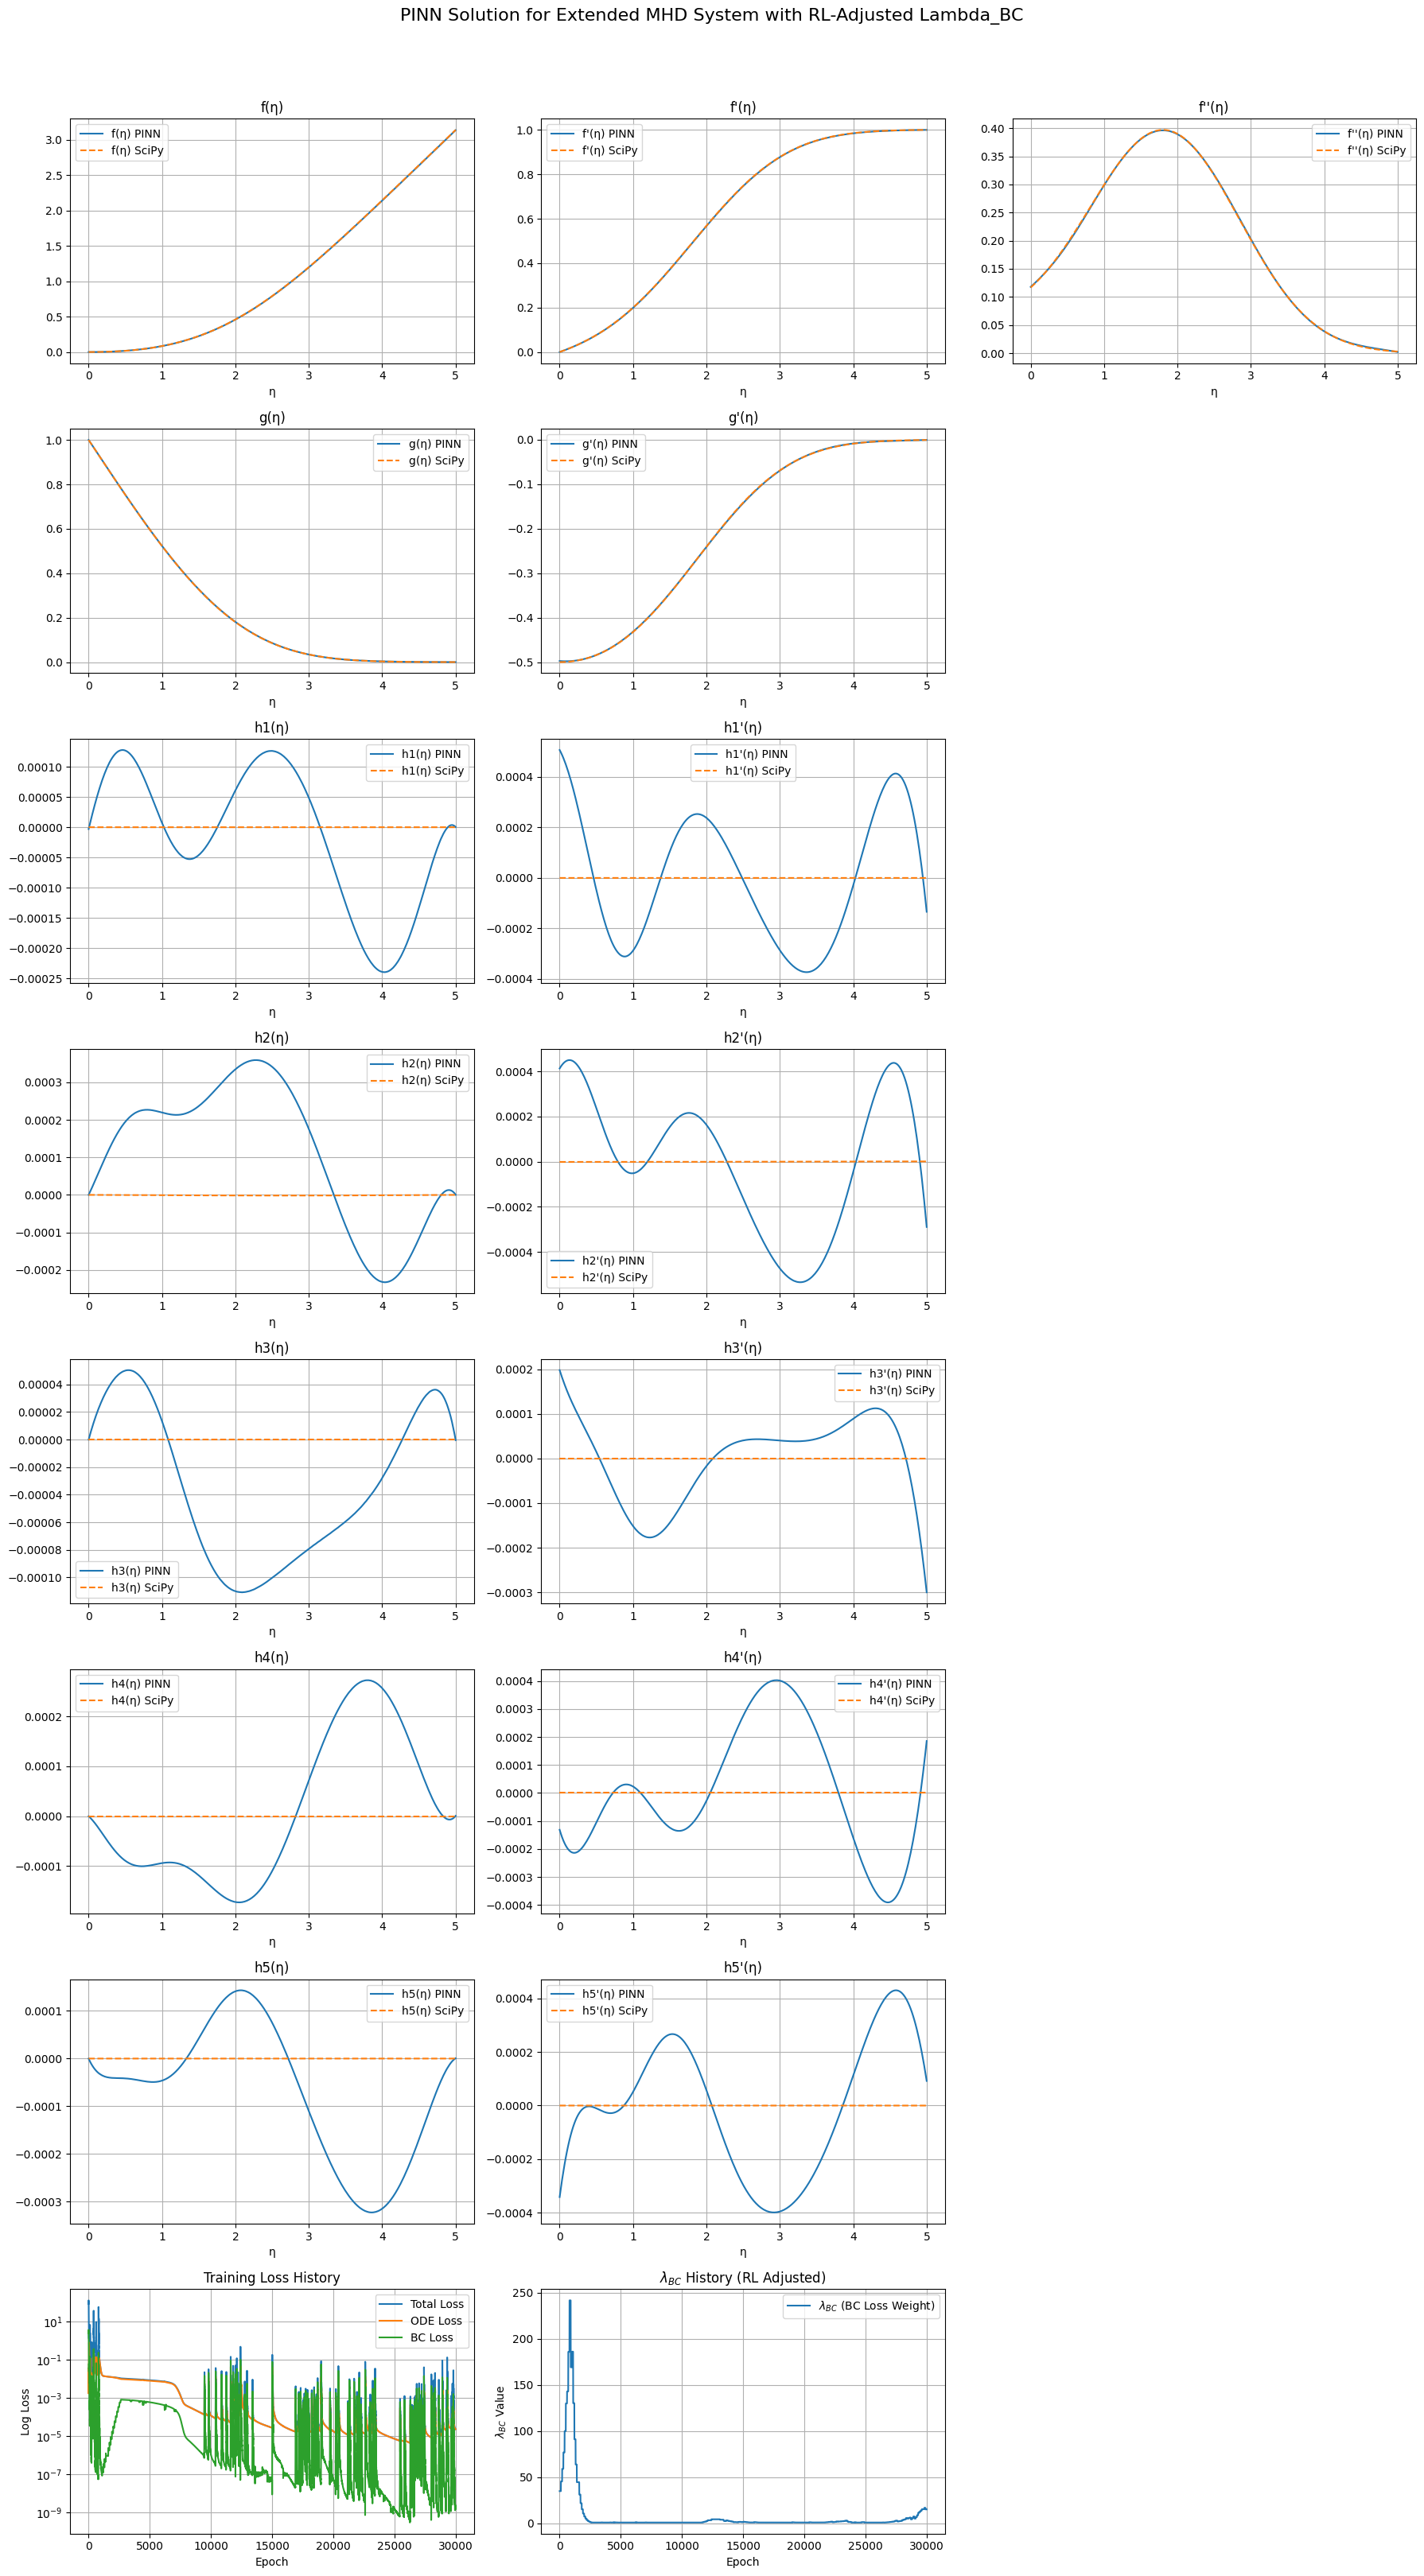


--- Final Loss Metrics (Extended System) ---
Final Total Loss: 2.3536e-05
Final ODE Residual Loss: 2.3511e-05
Final Boundary Condition Loss: 1.6295e-09
Final lambda_bc: 15.25
Mean Squared Error (PINN vs SciPy) for f(η): 6.3573e-06
Mean Squared Error (PINN vs SciPy) for g(η): 2.0350e-07
Mean Squared Error (PINN vs SciPy) for h1(η): 1.3101e-08
Mean Squared Error (PINN vs SciPy) for h2(η): 4.7739e-08
Mean Squared Error (PINN vs SciPy) for h3(η): 4.1242e-09
Mean Squared Error (PINN vs SciPy) for h4(η): 2.0959e-08
Mean Squared Error (PINN vs SciPy) for h5(η): 2.4773e-08

Core neural network model for the extended system saved to extended_mhd_pinn_rl_model.h5

--- Note on RL and System Complexity ---

This script attempts to solve a significantly more complex system of 7 coupled ODEs.
- The PINN training (epochs, network size, learning rate, loss weights) will likely require extensive tuning.
- The SciPy BVP solver ('solve_bvp') faces extreme difficulty with such large, coupled, non-linear 

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
import collections # For Q-table using defaultdict

# Suppress TensorFlow warnings for cleaner output
import logging
tf.get_logger().setLevel(logging.ERROR)

# --- 1. Define MHD and New System Parameters and Domain ---
M_param_val = 1.0
Pr_m_param_val = 1.0
ETA_MAX_val = 5.0 # Domain for eta

# Parameters for the 5 new equations (h1 to h5)
# These are placeholders based on your previous script.
# Ensure they represent the desired physical equations.
K_params_dict_tf = {
    'K1': tf.constant(0.5, dtype=tf.float32), 'K2': tf.constant(0.5, dtype=tf.float32),
    'K3': tf.constant(0.3, dtype=tf.float32), 'K4': tf.constant(0.2, dtype=tf.float32),
    'K5': tf.constant(0.4, dtype=tf.float32), 'K6': tf.constant(0.4, dtype=tf.float32),
    'K7': tf.constant(0.6, dtype=tf.float32), 'K8': tf.constant(0.3, dtype=tf.float32),
    'K9': tf.constant(0.2, dtype=tf.float32), 'K10': tf.constant(0.5, dtype=tf.float32),
}
# For SciPy, we'll need numpy versions
K_params_dict_np = {k: v.numpy() for k, v in K_params_dict_tf.items()}


# --- 2. Define the Neural Network Architecture ---
def create_pinn_model_extended(num_hidden_layers=6, num_neurons_per_layer=128): # Increased capacity
    eta_input = tf.keras.Input(shape=(1,), name="eta")
    x = eta_input
    for _ in range(num_hidden_layers):
        x = tf.keras.layers.Dense(num_neurons_per_layer, activation="tanh")(x)
    # Output f, g, h1, h2, h3, h4, h5 (7 outputs)
    f_output = tf.keras.layers.Dense(1, name="f", activation='linear')(x)
    g_output = tf.keras.layers.Dense(1, name="g", activation='linear')(x)
    h1_output = tf.keras.layers.Dense(1, name="h1", activation='linear')(x)
    h2_output = tf.keras.layers.Dense(1, name="h2", activation='linear')(x)
    h3_output = tf.keras.layers.Dense(1, name="h3", activation='linear')(x)
    h4_output = tf.keras.layers.Dense(1, name="h4", activation='linear')(x)
    h5_output = tf.keras.layers.Dense(1, name="h5", activation='linear')(x)
    return tf.keras.Model(inputs=eta_input, outputs=[f_output, g_output, h1_output, h2_output, h3_output, h4_output, h5_output])

# --- 3. Define the Extended PINN Model ---
class Extended_MHD_PINN(tf.keras.Model):
    def __init__(self, nn_approximator, m_const, pr_m_const, k_params_tf_dict_in, eta_max_const, initial_lambda_bc=50.0, **kwargs):
        super().__init__(**kwargs)
        self.nn = nn_approximator
        self.M = tf.constant(m_const, dtype=tf.float32)
        self.Pr_m = tf.constant(pr_m_const, dtype=tf.float32)
        self.K = k_params_tf_dict_in # Dictionary of K_params (TensorFlow constants)
        self.eta_max = tf.constant(eta_max_const, dtype=tf.float32)
        self.lambda_ode = tf.constant(1.0, dtype=tf.float32)
        self.lambda_bc = tf.Variable(initial_lambda_bc, dtype=tf.float32, trainable=False, name="lambda_bc")

    def set_lambda_bc(self, new_lambda_bc_value):
        # Clip to prevent extreme values that might destabilize training
        self.lambda_bc.assign(np.clip(new_lambda_bc_value, 1.0, 1000.0))

    def call(self, eta):
        return self.nn(eta)

    @tf.function
    def compute_derivatives_and_residuals(self, eta_collocation):
        # This function computes derivatives and ODE residuals.
        # It's called by loss_fn.
        with tf.GradientTape(persistent=True) as tape_outer: # For 3rd order f
            tape_outer.watch(eta_collocation)
            with tf.GradientTape(persistent=True) as tape_mid: # For 2nd order f, g, h_i
                tape_mid.watch(eta_collocation)
                with tf.GradientTape(persistent=True) as tape_inner: # For 1st order f, g, h_i
                    tape_inner.watch(eta_collocation)
                    # Get all 7 outputs from the neural network
                    f_pred, g_pred, h1_pred, h2_pred, h3_pred, h4_pred, h5_pred = self.nn(eta_collocation)

                all_preds_list = [f_pred, g_pred, h1_pred, h2_pred, h3_pred, h4_pred, h5_pred]
                # First derivatives
                first_derivs_list = [tape_inner.gradient(pred, eta_collocation) for pred in all_preds_list]
            del tape_inner # Release inner tape

            # Second derivatives
            second_derivs_list = [tape_mid.gradient(deriv, eta_collocation) for deriv in first_derivs_list]
        del tape_mid # Release mid tape

        # Third derivative for f only
        df_deta3 = tape_outer.gradient(second_derivs_list[0], eta_collocation) # second_derivs_list[0] is f''
        del tape_outer # Release outer tape

        # Assign derivatives to named variables for clarity
        f, fp, fpp = f_pred, first_derivs_list[0], second_derivs_list[0]
        fppp = df_deta3
        g, gp, gpp = g_pred, first_derivs_list[1], second_derivs_list[1]

        h_preds_list = all_preds_list[2:]    # h1_pred to h5_pred
        hp_preds_list = first_derivs_list[2:] # dh1_deta to dh5_deta
        hpp_preds_list = second_derivs_list[2:]# dh1_deta2 to dh5_deta2

        # Original MHD Residuals (ensure these match your physical equations)
        residual_f = fppp + f * fpp - self.M * (g * gpp + fpp * g)
        residual_g = gpp + self.Pr_m * (f * gp - fp * g)

        # New Residuals for h1 to h5 (example definitions based on your previous code structure)
        # Ensure these forms correctly represent the negative of the terms on the RHS of h_i'' = ...
        res_h1 = hpp_preds_list[0] + self.K['K1'] * f * hp_preds_list[0] - self.K['K2'] * g * h_preds_list[0]
        res_h2 = hpp_preds_list[1] + self.K['K3'] * fp * h_preds_list[1] - self.K['K4'] * gp * hp_preds_list[1]
        res_h3 = hpp_preds_list[2] + self.K['K5'] * hp_preds_list[0] * h_preds_list[2] - self.K['K6'] * h_preds_list[1] * hp_preds_list[2]
        res_h4 = hpp_preds_list[3] + self.K['K7'] * f * hp_preds_list[3] - self.K['K8'] * h_preds_list[0] * h_preds_list[3]
        res_h5 = hpp_preds_list[4] + self.K['K9'] * g * hp_preds_list[4] - self.K['K10'] * h_preds_list[1] * h_preds_list[4]

        all_residuals_h_list = [res_h1, res_h2, res_h3, res_h4, res_h5]

        return residual_f, residual_g, all_residuals_h_list


    @tf.function
    def loss_fn(self, eta_collocation, eta_boundary_0, eta_boundary_max):
        # ODE Residuals
        res_f_ode, res_g_ode, residuals_h_list_ode = self.compute_derivatives_and_residuals(eta_collocation)

        loss_ode_f = tf.reduce_mean(tf.square(res_f_ode))
        loss_ode_g = tf.reduce_mean(tf.square(res_g_ode))
        loss_ode_h_sum = tf.add_n([tf.reduce_mean(tf.square(res_h_i)) for res_h_i in residuals_h_list_ode])
        total_loss_ode = loss_ode_f + loss_ode_g + loss_ode_h_sum

        # Boundary Conditions
        # Network outputs at boundaries
        outputs_at_0_all_list = self.nn(eta_boundary_0) # [f, g, h1, ..., h5] at eta=0
        f_at_0, g_at_0 = outputs_at_0_all_list[0], outputs_at_0_all_list[1]
        h_at_0_list_vals = outputs_at_0_all_list[2:]

        outputs_at_max_all_list = self.nn(eta_boundary_max) # [f, g, h1, ..., h5] at eta=eta_max
        f_at_max, g_at_max = outputs_at_max_all_list[0], outputs_at_max_all_list[1]
        h_at_max_list_vals = outputs_at_max_all_list[2:]

        # Derivatives for Boundary Conditions (specifically for f'(0) and f'(eta_max))
        with tf.GradientTape(persistent=True) as tape_bc: # Persistent for multiple gradient calls if needed
            tape_bc.watch(eta_boundary_0)
            tape_bc.watch(eta_boundary_max)
            # Re-evaluate f at boundaries for gradient calculation
            # This is necessary because the f_at_0/max above are just tensors, not part of this tape's computation graph
            f_for_grad_at_0, _, _, _, _, _, _ = self.nn(eta_boundary_0)
            f_for_grad_at_max, _, _, _, _, _, _ = self.nn(eta_boundary_max)

        f_prime_at_0 = tape_bc.gradient(f_for_grad_at_0, eta_boundary_0)
        f_prime_at_max = tape_bc.gradient(f_for_grad_at_max, eta_boundary_max)
        del tape_bc # Important: Delete persistent tape when done

        # BCs for f and g (as defined previously)
        bc_f0_val = f_at_0 - 0.0                       # f(0) = 0
        bc_fprime0_val = f_prime_at_0 - 0.0            # f'(0) = 0
        bc_g0_val = g_at_0 - 1.0                       # g(0) = 1
        bc_fprime_max_val = f_prime_at_max - 1.0       # f'(eta_max) = 1
        bc_g_max_val = g_at_max - 0.0                  # g(eta_max) = 0

        loss_bc_fg = (tf.reduce_mean(tf.square(bc_f0_val)) +
                      tf.reduce_mean(tf.square(bc_fprime0_val)) +
                      tf.reduce_mean(tf.square(bc_g0_val)) +
                      tf.reduce_mean(tf.square(bc_fprime_max_val)) +
                      tf.reduce_mean(tf.square(bc_g_max_val)))

        # Example Boundary conditions for h1 to h5: h_i(0) = 0, h_i(ETA_MAX) = 0.
        # Adjust these target values (0.0) if your physical BCs are different.
        loss_bc_h_sum = tf.constant(0.0, dtype=tf.float32)
        for i in range(5): # For h1 to h5
            # BC: h_i(0) = 0
            bc_hi_0_val = h_at_0_list_vals[i] - 0.0
            loss_bc_h_sum += tf.reduce_mean(tf.square(bc_hi_0_val))
            # BC: h_i(ETA_MAX) = 0
            bc_hi_max_val = h_at_max_list_vals[i] - 0.0
            loss_bc_h_sum += tf.reduce_mean(tf.square(bc_hi_max_val))
            # If BCs for h_i involved derivatives (e.g., h_i'(0) = value),
            # you would need to calculate those derivatives using tape_bc similar to f_prime_at_0.

        total_loss_bc = loss_bc_fg + loss_bc_h_sum
        # Weighted sum for total loss
        total_loss = self.lambda_ode * total_loss_ode + self.lambda_bc * total_loss_bc
        return total_loss, total_loss_ode, total_loss_bc

    @tf.function
    def gradient_update_step(self, optimizer, eta_collocation, eta_boundary_0, eta_boundary_max):
        with tf.GradientTape() as tape:
            total_loss, loss_ode, loss_bc = self.loss_fn(eta_collocation, eta_boundary_0, eta_boundary_max)
        gradients = tape.gradient(total_loss, self.nn.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.nn.trainable_variables))
        return total_loss, loss_ode, loss_bc

# --- 4. Q-Learning Agent ---
class QLearningAgent:
    def __init__(self, actions, learning_rate=0.1, discount_factor=0.9, exploration_rate=0.2): # Slightly higher exploration
        self.actions = actions
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.q_table = collections.defaultdict(lambda: np.zeros(len(actions)))

    def get_state(self, loss_ode, loss_bc, epoch, total_epochs):
        # Discretize state based on loss ratio and training phase
        # Handle potential zero losses to avoid division by zero or NaN ratios
        if loss_ode < 1e-12 and loss_bc < 1e-12: ratio_discrete = 1 # Both effectively zero, balanced
        elif loss_ode < 1e-12: ratio_discrete = 2 # BC dominant if ODE is zero
        elif loss_bc < 1e-12: ratio_discrete = 0 # ODE dominant if BC is zero
        else:
            ratio = loss_bc / loss_ode
            if ratio < 0.5: ratio_discrete = 0      # ODE loss is relatively larger
            elif ratio > 2.0: ratio_discrete = 2    # BC loss is relatively larger
            else: ratio_discrete = 1                # Balanced

        if epoch < total_epochs / 3: phase = 0      # Early training phase
        elif epoch < 2 * total_epochs / 3: phase = 1 # Mid training phase
        else: phase = 2                             # Late training phase
        return (ratio_discrete, phase)

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(len(self.actions))  # Explore: random action
        else:
            q_values = self.q_table[state]
            return np.argmax(q_values)  # Exploit: best known action for this state

    def update_q_table(self, state, action_idx, reward, next_state):
        old_q_value = self.q_table[state][action_idx]
        # Max Q-value for the next state (if next_state is new, its Q-values are 0 by defaultdict)
        future_q_value = np.max(self.q_table[next_state])
        # Q-learning formula
        new_q_value = old_q_value + self.lr * (reward + self.gamma * future_q_value - old_q_value)
        self.q_table[state][action_idx] = new_q_value

# --- 5. Generate Training Data ---
N_collocation = 2500 # Number of collocation points inside the domain
N_boundary = 250   # Number of points on each boundary for averaging BC loss
# Ensure collocation points are not exactly at the boundaries for stability with some derivative forms
eta_col_np = np.random.uniform(1e-5, ETA_MAX_val - 1e-5, (N_collocation, 1)).astype(np.float32)
eta_b0_np = np.full((N_boundary, 1), 0.0, dtype=np.float32)         # eta = 0 points
eta_b_max_np = np.full((N_boundary, 1), ETA_MAX_val, dtype=np.float32) # eta = ETA_MAX points

eta_col = tf.constant(eta_col_np)
eta_b0 = tf.constant(eta_b0_np)
eta_b_max = tf.constant(eta_b_max_np)

# --- 6. Training the Extended PINN with RL Agent ---
nn_core_model_ext = create_pinn_model_extended(num_hidden_layers=6, num_neurons_per_layer=128)
initial_lambda_bc_val = 50.0 # Starting weight for BC loss; may need significant tuning
pinn_solver_ext = Extended_MHD_PINN(nn_core_model_ext, M_param_val, Pr_m_param_val, K_params_dict_tf, ETA_MAX_val, initial_lambda_bc=initial_lambda_bc_val)

initial_learning_rate = 1e-3 # Adam optimizer learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=2000, decay_rate=0.90, staircase=True # Learning rate decay
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

epochs = 30000 # Number of training epochs; complex systems need more
print_interval = 1000 # How often to print loss
rl_update_interval = 100 # How often the RL agent adjusts lambda_bc and learns

# RL Agent Actions: multipliers for current lambda_bc
lambda_bc_actions_multipliers = [0.7, 0.9, 1.0, 1.1, 1.3] # Decrease, slight decrease, keep, slight increase, increase
rl_agent = QLearningAgent(actions=lambda_bc_actions_multipliers, exploration_rate=0.25, learning_rate=0.1)

print(f"Starting PINN training for {epochs} epochs with RL-adjusted lambda_bc (Extended System)...")
history_loss, history_loss_ode, history_loss_bc, history_lambda_bc = [], [], [], []

# Variables to store state and action for Q-learning update
state_at_action_taken = None
action_idx_taken = None

for epoch in range(epochs):
    lambda_to_log_this_epoch = pinn_solver_ext.lambda_bc.numpy() # Log lambda_bc active for this step

    # RL Agent Interaction (takes action at the START of an interval)
    if epoch % rl_update_interval == 0 :
        # Use losses from the end of the PREVIOUS interval to decide current action
        current_ode_loss = history_loss_ode[-1] if history_loss_ode else 0.1 # Handle empty history at epoch 0
        current_bc_loss = history_loss_bc[-1] if history_loss_bc else 0.1

        state_at_action_taken = rl_agent.get_state(current_ode_loss, current_bc_loss, epoch, epochs)
        action_idx_taken = rl_agent.choose_action(state_at_action_taken)
        multiplier = rl_agent.actions[action_idx_taken]

        new_lambda_bc = pinn_solver_ext.lambda_bc.numpy() * multiplier
        pinn_solver_ext.set_lambda_bc(new_lambda_bc)
        lambda_to_log_this_epoch = pinn_solver_ext.lambda_bc.numpy() # Update logged lambda if changed
        # print(f"Epoch {epoch+1}: RL Action: mult={multiplier:.2f}, new lambda_bc={lambda_to_log_this_epoch:.2f}")

    # Perform one PINN training step
    total_loss_val, loss_ode_val, loss_bc_val = pinn_solver_ext.gradient_update_step(
        optimizer, eta_col, eta_b0, eta_b_max
    )

    # RL Agent Learning (updates Q-table at the END of an interval, using outcome)
    if epoch > 0 and epoch % rl_update_interval == (rl_update_interval -1) : # End of an RL interval
        if state_at_action_taken is not None and action_idx_taken is not None: # Ensure an action was taken for this interval
            # Reward: negative change in total loss over the interval. Higher reward if loss decreased.
            # Compare current total loss with the loss at the start of this RL interval
            reward_start_loss_index = max(0, len(history_loss) - rl_update_interval +1) # +1 because current loss isn't added yet
            if reward_start_loss_index < len(history_loss):
                 reward = -(total_loss_val.numpy() - history_loss[reward_start_loss_index])
            else: # Fallback for very early steps or if history is short
                 reward = -total_loss_val.numpy()

            # Next state is based on losses AFTER the interval's training steps
            next_state = rl_agent.get_state(loss_ode_val.numpy(), loss_bc_val.numpy(), epoch + 1, epochs)
            rl_agent.update_q_table(state_at_action_taken, action_idx_taken, reward, next_state)
            state_at_action_taken, action_idx_taken = None, None # Reset for next interval

    # Log history for this epoch
    history_loss.append(total_loss_val.numpy())
    history_loss_ode.append(loss_ode_val.numpy())
    history_loss_bc.append(loss_bc_val.numpy())
    history_lambda_bc.append(lambda_to_log_this_epoch)

    if (epoch + 1) % print_interval == 0 or epoch == 0:
        lr_to_print = optimizer.learning_rate
        if callable(lr_to_print):
            current_lr_tensor = lr_to_print(optimizer.iterations)
        else:
            current_lr_tensor = lr_to_print
        current_lr_val_np = current_lr_tensor.numpy()

        print(f"Epoch {epoch+1}/{epochs} - Total Loss: {total_loss_val:.3e}, "
              f"ODE: {loss_ode_val:.3e}, BC: {loss_bc_val:.3e}, "
              f"lambda_bc: {lambda_to_log_this_epoch:.2f}, LR: {current_lr_val_np:.2e}")
print("Training finished.")

# --- 7. Prediction and Plotting (Extended) ---
print("\nGenerating predictions and plots for the extended system...")
eta_plot_tf = tf.constant(np.linspace(0, ETA_MAX_val, 300).reshape(-1, 1).astype(np.float32))
outputs_pinn_pred_tf_list = pinn_solver_ext.nn(eta_plot_tf)
f_pinn_pred_tf, g_pinn_pred_tf = outputs_pinn_pred_tf_list[0], outputs_pinn_pred_tf_list[1]
h_pinn_preds_tf_list = outputs_pinn_pred_tf_list[2:]

# Derivatives for plotting
with tf.GradientTape(persistent=True) as tape_plot_outer:
    tape_plot_outer.watch(eta_plot_tf)
    with tf.GradientTape(persistent=True) as tape_plot_mid:
        tape_plot_mid.watch(eta_plot_tf)
        with tf.GradientTape(persistent=True) as tape_plot_inner:
            tape_plot_inner.watch(eta_plot_tf)
            # Re-evaluate on plot points within tape context for gradients
            f_plot_eval, g_plot_eval, h1_plot_eval, h2_plot_eval, h3_plot_eval, h4_plot_eval, h5_plot_eval = pinn_solver_ext.nn(eta_plot_tf)

        fp_plot_tf = tape_plot_inner.gradient(f_plot_eval, eta_plot_tf)
        gp_plot_tf = tape_plot_inner.gradient(g_plot_eval, eta_plot_tf)
        hp_plots_tf_list = [tape_plot_inner.gradient(h_plot_eval, eta_plot_tf) for h_plot_eval in [h1_plot_eval, h2_plot_eval, h3_plot_eval, h4_plot_eval, h5_plot_eval]]
    del tape_plot_inner

    fpp_plot_tf = tape_plot_mid.gradient(fp_plot_tf, eta_plot_tf)
    # gpp_plot_tf = tape_plot_mid.gradient(gp_plot_tf, eta_plot_tf) # If needed for plotting
    # hpp_plots_tf_list = [tape_plot_mid.gradient(hp_p_tf, eta_plot_tf) for hp_p_tf in hp_plots_tf_list] # If h'' are plotted
del tape_plot_mid
del tape_plot_outer # Corrected del statement

# Convert to numpy for plotting
f_pinn_pred_np = f_pinn_pred_tf.numpy()
g_pinn_pred_np = g_pinn_pred_tf.numpy()
h_pinn_preds_np_list = [h_tf.numpy() for h_tf in h_pinn_preds_tf_list]
f_prime_pinn_pred_np = fp_plot_tf.numpy()
g_prime_pinn_pred_np = gp_plot_tf.numpy()
h_prime_pinn_preds_np_list = [hp_tf.numpy() for hp_tf in hp_plots_tf_list]
f_prime_prime_pinn_pred_np = fpp_plot_tf.numpy()

# SciPy Solution for the Extended System (15 states for SciPy: f,f',f'', g,g', h1,h1', ..., h5,h5')
def extended_mhd_ode_system_scipy(eta, y, M_val_in, Pr_m_val_in, K_vals_np_dict_in):
    f_s, fp_s, fpp_s = y[0], y[1], y[2]
    g_s, gp_s = y[3], y[4]
    h_s_vals_list = [y[5 + 2 * i] for i in range(5)]
    hp_s_vals_list = [y[6 + 2 * i] for i in range(5)]

    # Calculate terms needed for highest derivatives
    gpp_s_calc = -Pr_m_val_in * (f_s * gp_s - fp_s * g_s) # This is g''
    fppp_s_calc = -f_s * fpp_s + M_val_in * (g_s * gpp_s_calc + fpp_s * g_s) # This is f'''

    hpp_s_calc_list = [0.0]*5 # h_i''
    hpp_s_calc_list[0] = -K_vals_np_dict_in['K1'] * f_s * hp_s_vals_list[0] + K_vals_np_dict_in['K2'] * g_s * h_s_vals_list[0]
    hpp_s_calc_list[1] = -K_vals_np_dict_in['K3'] * fp_s * h_s_vals_list[1] + K_vals_np_dict_in['K4'] * gp_s * hp_s_vals_list[1]
    hpp_s_calc_list[2] = -K_vals_np_dict_in['K5'] * hp_s_vals_list[0] * h_s_vals_list[2] + K_vals_np_dict_in['K6'] * h_s_vals_list[1] * hp_s_vals_list[2]
    hpp_s_calc_list[3] = -K_vals_np_dict_in['K7'] * f_s * hp_s_vals_list[3] + K_vals_np_dict_in['K8'] * h_s_vals_list[0] * h_s_vals_list[3]
    hpp_s_calc_list[4] = -K_vals_np_dict_in['K9'] * g_s * hp_s_vals_list[4] + K_vals_np_dict_in['K10'] * h_s_vals_list[1] * h_s_vals_list[4]

    # Assemble the derivatives vector [f', f'', f''', g', g'', h1', h1'', ..., h5', h5'']
    derivs_to_return = np.zeros_like(y)
    derivs_to_return[0], derivs_to_return[1], derivs_to_return[2] = fp_s, fpp_s, fppp_s_calc
    derivs_to_return[3], derivs_to_return[4] = gp_s, gpp_s_calc
    for i in range(5):
        derivs_to_return[5 + 2 * i] = hp_s_vals_list[i]        # h_i'
        derivs_to_return[6 + 2 * i] = hpp_s_calc_list[i]     # h_i''
    return derivs_to_return

def extended_mhd_bc_scipy(ya, yb, M_val_in, Pr_m_val_in, K_vals_np_dict_in):
    # ya/yb are the solution vectors [f,f',f'',g,g',h1,h1',...,h5,h5'] at eta=0 and eta=ETA_MAX
    bc_residuals_list = [
        ya[0] - 0.0,  # f(0)=0
        ya[1] - 0.0,  # f'(0)=0
        yb[1] - 1.0,  # f'(eta_max)=1
        ya[3] - 1.0,  # g(0)=1
        yb[3] - 0.0,  # g(eta_max)=0
    ]
    for i in range(5): # For h1 to h5, example BCs: h_i(0)=0, h_i(eta_max)=0
        bc_residuals_list.append(ya[5 + 2 * i] - 0.0)  # h_i(0)=0
        bc_residuals_list.append(yb[5 + 2 * i] - 0.0)  # h_i(eta_max)=0
    return np.array(bc_residuals_list)

eta_scipy_mesh_ext = np.linspace(0, ETA_MAX_val, 150) # Mesh for BVP solver
y_init_guess_ext = np.zeros((15, eta_scipy_mesh_ext.size)) # 15 state variables for SciPy

# Attempt more informed (but still basic) initial guesses for SciPy
y_init_guess_ext[1, :] = eta_scipy_mesh_ext / ETA_MAX_val # f' approx linear 0 to 1
y_init_guess_ext[0, :] = y_init_guess_ext[1,:] * eta_scipy_mesh_ext / 2.0 # f approx quadratic
y_init_guess_ext[2, :] = 1.0 / ETA_MAX_val # f'' approx constant
y_init_guess_ext[3, :] = 1.0 - (eta_scipy_mesh_ext / ETA_MAX_val) # g approx linear 1 to 0
y_init_guess_ext[4, :] = -1.0 / ETA_MAX_val # g' approx constant negative
# For h_i, h_i', simple parabolic shapes for h_i(0)=0, h_i(max)=0, peaking (small) at midpoint
for i in range(5):
    idx_h = 5 + 2*i
    idx_hp = 6 + 2*i
    # A small parabolic bump for h_i, zero for h_i' is often better than all zeros
    y_init_guess_ext[idx_h, :] = 0.01 * (eta_scipy_mesh_ext * (ETA_MAX_val - eta_scipy_mesh_ext)) / (ETA_MAX_val**2 / 4)
    y_init_guess_ext[idx_hp, :] = 0.0 # Start with zero derivative if unsure

print("Solving with SciPy BVP solver for the extended system (this is very challenging and may take time or fail)...")
scipy_solved_ext = False
# Initialize SciPy result arrays with NaNs for robust plotting if SciPy fails
nan_plot_shape = eta_plot_tf.numpy().flatten().shape
f_s, fp_s, fpp_s = [np.full(nan_plot_shape, np.nan) for _ in range(3)]
g_s, gp_s = [np.full(nan_plot_shape, np.nan) for _ in range(2)]
h_s_list_scipy, hp_s_list_scipy = [[np.full(nan_plot_shape, np.nan) for _ in range(5)] for _ in range(2)]

try:
    sol_scipy_ext = solve_bvp(
        lambda eta, y: extended_mhd_ode_system_scipy(eta, y, M_param_val, Pr_m_param_val, K_params_dict_np),
        lambda ya, yb: extended_mhd_bc_scipy(ya, yb, M_param_val, Pr_m_param_val, K_params_dict_np),
        eta_scipy_mesh_ext, y_init_guess_ext, verbose=1, max_nodes=25000, tol=1e-3 # Relaxed tolerance, more nodes
    )
    if sol_scipy_ext.success:
        print(f"SciPy BVP solver (Extended) converged: {sol_scipy_ext.message}")
        y_scipy_plot_ext = sol_scipy_ext.sol(eta_plot_tf.numpy().flatten()) # Evaluate solution on PINN's plot points
        f_s, fp_s, fpp_s = y_scipy_plot_ext[0], y_scipy_plot_ext[1], y_scipy_plot_ext[2]
        g_s, gp_s = y_scipy_plot_ext[3], y_scipy_plot_ext[4]
        for i in range(5):
            h_s_list_scipy[i] = y_scipy_plot_ext[5 + 2 * i]
            hp_s_list_scipy[i] = y_scipy_plot_ext[6 + 2 * i]
        scipy_solved_ext = True
    else: print(f"SciPy BVP solver (Extended) FAILED to converge: {sol_scipy_ext.message}")
except Exception as e: print(f"Error during SciPy BVP solution (Extended): {e}")


# Plotting
num_h_funcs = 5
# Rows: f(1), g(1), h_i(5 rows, 1 per h_i), loss/lambda (1 row)
num_plot_rows = 1 + 1 + num_h_funcs + 1
plt.figure(figsize=(18, 4 * num_plot_rows + 1)) # Adjusted figure height
eta_np_flat = eta_plot_tf.numpy().flatten()

plot_row_counter = 1 # Helper to manage subplot rows

# Plot f and its derivatives
plt.subplot(num_plot_rows, 3, (plot_row_counter -1) * 3 + 1); plt.plot(eta_np_flat, f_pinn_pred_np.flatten(), label='f(η) PINN'); plt.plot(eta_np_flat, f_s, label='f(η) SciPy', ls='--'); plt.title('f(η)'); plt.xlabel('η'); plt.legend(); plt.grid(True);
plt.subplot(num_plot_rows, 3, (plot_row_counter -1) * 3 + 2); plt.plot(eta_np_flat, f_prime_pinn_pred_np.flatten(), label="f'(η) PINN"); plt.plot(eta_np_flat, fp_s, label="f'(η) SciPy", ls='--'); plt.title("f'(η)"); plt.xlabel('η'); plt.legend(); plt.grid(True);
plt.subplot(num_plot_rows, 3, (plot_row_counter -1) * 3 + 3); plt.plot(eta_np_flat, f_prime_prime_pinn_pred_np.flatten(), label="f''(η) PINN"); plt.plot(eta_np_flat, fpp_s, label="f''(η) SciPy", ls='--'); plt.title("f''(η)"); plt.xlabel('η'); plt.legend(); plt.grid(True);
plot_row_counter += 1

# Plot g and its derivative
plt.subplot(num_plot_rows, 3, (plot_row_counter -1) * 3 + 1); plt.plot(eta_np_flat, g_pinn_pred_np.flatten(), label='g(η) PINN'); plt.plot(eta_np_flat, g_s, label='g(η) SciPy', ls='--'); plt.title('g(η)'); plt.xlabel('η'); plt.legend(); plt.grid(True);
plt.subplot(num_plot_rows, 3, (plot_row_counter -1) * 3 + 2); plt.plot(eta_np_flat, g_prime_pinn_pred_np.flatten(), label="g'(η) PINN"); plt.plot(eta_np_flat, gp_s, label="g'(η) SciPy", ls='--'); plt.title("g'(η)"); plt.xlabel('η'); plt.legend(); plt.grid(True);
plt.subplot(num_plot_rows, 3, (plot_row_counter -1) * 3 + 3).axis('off') # Empty plot for g row
plot_row_counter += 1

# Plot h_i functions and their first derivatives
for i in range(num_h_funcs):
    plt.subplot(num_plot_rows, 3, (plot_row_counter -1) * 3 + 1); plt.plot(eta_np_flat, h_pinn_preds_np_list[i].flatten(), label=f'h{i+1}(η) PINN'); plt.plot(eta_np_flat, h_s_list_scipy[i], label=f'h{i+1}(η) SciPy', ls='--'); plt.title(f'h{i+1}(η)'); plt.xlabel('η'); plt.legend(); plt.grid(True);
    plt.subplot(num_plot_rows, 3, (plot_row_counter -1) * 3 + 2); plt.plot(eta_np_flat, h_prime_pinn_preds_np_list[i].flatten(), label=f"h{i+1}'(η) PINN"); plt.plot(eta_np_flat, hp_s_list_scipy[i], label=f"h{i+1}'(η) SciPy", ls='--'); plt.title(f"h{i+1}'(η)"); plt.xlabel('η'); plt.legend(); plt.grid(True);
    plt.subplot(num_plot_rows, 3, (plot_row_counter -1) * 3 + 3).axis('off') # Empty plot
    plot_row_counter += 1

# Loss and Lambda_bc history plots
plt.subplot(num_plot_rows, 3, (plot_row_counter - 1) * 3 + 1)
plt.plot(history_loss, label='Total Loss'); plt.plot(history_loss_ode, label='ODE Loss'); plt.plot(history_loss_bc, label='BC Loss')
plt.xlabel('Epoch'); plt.ylabel('Log Loss'); plt.yscale('log'); plt.title('Training Loss History'); plt.legend(); plt.grid(True)

plt.subplot(num_plot_rows, 3, (plot_row_counter - 1) * 3 + 2)
plt.plot(history_lambda_bc, label='$\lambda_{BC}$ (BC Loss Weight)')
plt.xlabel('Epoch'); plt.ylabel('$\lambda_{BC}$ Value'); plt.title('$\lambda_{BC}$ History (RL Adjusted)'); plt.legend(); plt.grid(True)
plt.subplot(num_plot_rows, 3, (plot_row_counter - 1) * 3 + 3).axis('off') # Empty

plt.suptitle("PINN Solution for Extended MHD System with RL-Adjusted Lambda_BC", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect for suptitle
plt.show()


# --- 8. Accuracy (Extended) ---
final_total_loss = history_loss[-1] if history_loss else float('nan')
final_ode_loss = history_loss_ode[-1] if history_loss_ode else float('nan')
final_bc_loss = history_loss_bc[-1] if history_loss_bc else float('nan')
final_lambda = history_lambda_bc[-1] if history_lambda_bc else initial_lambda_bc_val

print(f"\n--- Final Loss Metrics (Extended System) ---")
print(f"Final Total Loss: {final_total_loss:.4e}")
print(f"Final ODE Residual Loss: {final_ode_loss:.4e}")
print(f"Final Boundary Condition Loss: {final_bc_loss:.4e}")
print(f"Final lambda_bc: {final_lambda:.2f}")

if scipy_solved_ext:
    mse_f = np.mean(np.square(f_pinn_pred_np.flatten() - f_s.flatten())) if not np.isnan(f_s).all() else float('nan')
    mse_g = np.mean(np.square(g_pinn_pred_np.flatten() - g_s.flatten())) if not np.isnan(g_s).all() else float('nan')
    print(f"Mean Squared Error (PINN vs SciPy) for f(η): {mse_f:.4e}")
    print(f"Mean Squared Error (PINN vs SciPy) for g(η): {mse_g:.4e}")
    for i in range(num_h_funcs):
        mse_h_i = np.mean(np.square(h_pinn_preds_np_list[i].flatten() - h_s_list_scipy[i].flatten())) if not np.isnan(h_s_list_scipy[i]).all() else float('nan')
        print(f"Mean Squared Error (PINN vs SciPy) for h{i+1}(η): {mse_h_i:.4e}")
else:
    print("SciPy solution for the extended system was not successful or not available. MSE comparison not available.")


# --- 9. Save the Model (Extended) ---
model_filename_ext = "extended_mhd_pinn_rl_model.h5" # Using .keras extension as recommended
pinn_solver_ext.nn.save(model_filename_ext)
print(f"\nCore neural network model for the extended system saved to {model_filename_ext}")

# --- 10. Note on RL and System Complexity (from previous response) ---
print("\n--- Note on RL and System Complexity ---")
print("""
This script attempts to solve a significantly more complex system of 7 coupled ODEs.
- The PINN training (epochs, network size, learning rate, loss weights) will likely require extensive tuning.
- The SciPy BVP solver ('solve_bvp') faces extreme difficulty with such large, coupled, non-linear systems. Convergence is highly sensitive to initial guesses and solver parameters, and may often fail. The results should be interpreted with caution.
- The simple Q-learning agent is illustrative; its impact on such a complex training dynamic would also need careful study and potential enhancements.
- If you intend to solve equations with literal 8th-10th order derivatives for a single function, those specific equations and their (many) boundary conditions must be provided. The current setup uses a system of coupled 2nd and 3rd order ODEs.
""")